# Машинное обучение

## Обучение с учителем: качество модели

[yandex_practicum](https://practicum.yandex.ru/learn/data-scientist/courses/7003ed02-62c7-4cb8-96de-ac10f3bfb19e/sprints/197574/topics/69231b00-9a4c-4392-96e5-26994e6bcfd7/lessons/85fa7b7d-0060-44bb-bd83-ac26a345c91f/)

Почему нужны дополнительные модели для классификации?

Линейная и логистические регрессии прогнозируют целевой признак с помощью линейного уравнения. Такие модели хорошо работают <font color='red'>на качественных данных с линейной связью</font> . На практике специалисты часто имеют дело с нелинейной зависимостью и вовсе не идеальными датасетами — <font color='red'>с выбросами, недостатком наблюдений... </font> 

Чтобы помочь бизнесу при таких вводных, нужны другие модели машинного обучения.

Постановка задачи

Компания «Морские вкусняхи» доставляет корпоративным клиентам блюда из морепродуктов — устрицы, мидии и строганину из разных сортов рыб. На прибыль сильно влияет отмена заказов, потому что их не оплачивают, а товар приходится выбрасывать. Морепродукты нельзя замораживать повторно, иначе портится вкус. Менеджмент задумал отбивать себестоимость и ввести предоплату, но для этого необходима модель, которая будет предсказывать отмену заказов.

Опыт показывает, что эта мера отпугивает 20% клиентов. Решено запрашивать предоплату 70% в тех случаях, когда есть явный риск отмены заказа. Специалисту по Data Science — то есть вам — нужно научиться предсказывать такие случаи. При этом важно сэкономить больше 1 млн 100 тыс. рублей, чтобы окупить затраты на новое решение.

In [2]:
# библиотеки для работы с данными
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import random

# бибилотеки для подготовки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# библиотеки для линейной регрессии
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# библиотеки для логистической регрессии
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score


# добавим библиотеку для построения scatter диаграмм рассеяния с тренд-линиями
import plotly.express as px 
import plotly.graph_objects as go

import math

In [3]:
data = pd.read_csv('/Users/tony_builder/Documents/GitHub/studying/yandex_practicum/8_supervised_learning/orders_seafood.csv')

In [4]:
data.head()

client_id  reject_count  confirm_count  last_summ    summ_  count_position  \
0       8195            27             13   132684.4  34875.3              18   
1      16392            29             15   149790.1  19537.4              11   
2      16396            25             17    80195.2  44583.0              23   
3       8206            22             10    80089.5  22561.6              15   
4      16398            14             14   163565.6  27986.4              17   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [5]:
data.shape

(750, 7)

Информация о датасете

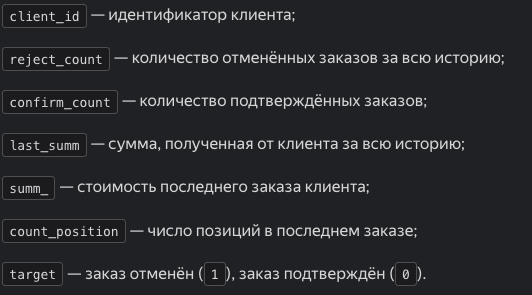

### Исследовательский анализ данных

In [6]:
data.describe().T

count           mean           std      min       25%  \
client_id       750.0    8911.952000   6815.642179     25.0   1030.25   
reject_count    750.0      20.524000      6.190896      5.0     16.00   
confirm_count   750.0      43.281333     55.671117      5.0     14.00   
last_summ       750.0  117236.968533  33535.611602  32896.4  98092.80   
summ_           750.0   13642.938933  11264.546470   1460.1   5028.40   
count_position  750.0       8.010667      6.231184      1.0      3.00   
target          750.0       0.700000      0.458563      0.0      0.00   

                     50%        75%       max  
client_id         8928.0   16768.00   17776.0  
reject_count        21.0      25.00      39.0  
confirm_count       17.0      24.75     204.0  
last_summ       120045.1  142483.85  191564.8  
summ_             8134.7   22788.95   69465.9  
count_position       5.0      13.00      30.0  
target               1.0       1.00       1.0

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       750 non-null    int64  
 1   reject_count    750 non-null    int64  
 2   confirm_count   750 non-null    int64  
 3   last_summ       750 non-null    float64
 4   summ_           750 non-null    float64
 5   count_position  750 non-null    int64  
 6   target          750 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 41.1 KB


In [8]:
numeric_columns = ['reject_count', 'confirm_count', 'last_summ', 'summ_', 'count_position']

categorical_columns = ['target']

In [9]:
dict_names = {'reject_count': 'число отмененных заказов',
              'confirm_count': 'число подтвержденных заказов',
              'last_summ': 'сумма заказов за всю историю',
              'summ_': 'сумма последнего заказа',
              'count_position': 'число позиций в последнем заказе',
              'target': 'статус заказа (отменен/ не отменен)'

}

Функция для построения гистограммы и boxplot для числовых признаков на одном графике. Причем гистограмма будет ограничена размерами усов. все выбросы мы сможем увидеть на box-plot

In [10]:
# функция гистограммы и boxplot на одном графике

def hist_boxplot(data, col, dataset_name, dict_names):
    df_for_plot= data[col]

    # Рассчитываем квантили
    q25, q75 = df_for_plot.quantile(0.25), df_for_plot.quantile(0.75)
    min_val = int(q25- 1.5*(q75-q25))
    max_val= int(q75 +  1.5*(q75-q25))

    # Создаем новый график
    plt.figure(figsize=(10, 6))

    # Строим гистограмму
    plt.subplot(2, 1, 1)  # 2 строки, 1 столбец, график 1
    plt.hist(df_for_plot, bins=20, range=(min_val, max_val))
    plt.title(f'Гистограмма датасета {dataset_name} для признака {dict_names[col]}')
    plt.xlabel(f'значения признака {dict_names[col]}')
    plt.ylabel(f'Частота')


    # Помечаем квартили на гистограмме
    plt.axvline(q25, color='r', linestyle='--', label='25th percentile')
    plt.axvline(q75, color='g', linestyle='--', label='75th percentile')
    plt.legend()

    # Строим график boxplot
    plt.subplot(2, 1, 2)  # 2 строки, 1 столбец, график 2
    plt.boxplot(df_for_plot, vert=False)
    plt.title(f'Boxplot признака {dict_names[col]} ')
    plt.xlabel(f'Значение признака {dict_names[col]}')

    # Помечаем квартили на boxplot
    plt.axvline(q25, color='r', linestyle='--', label='25th percentile')
    plt.axvline(q75, color='g', linestyle='--', label='75th percentile')
    plt.legend()


    # Показываем графики
    plt.tight_layout()  # Для автоматического выравнивания графиков
    plt.show()


        

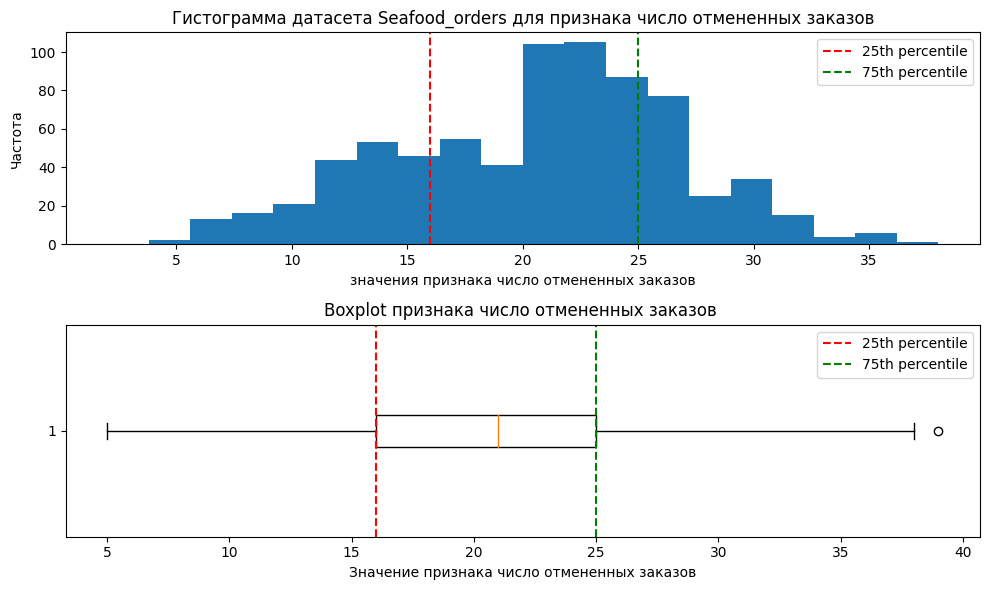

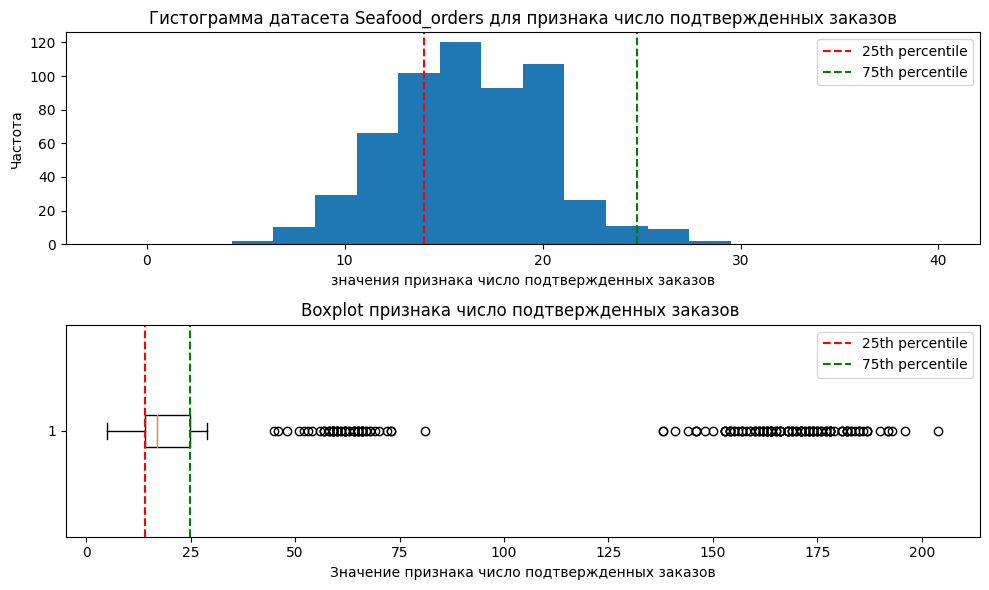

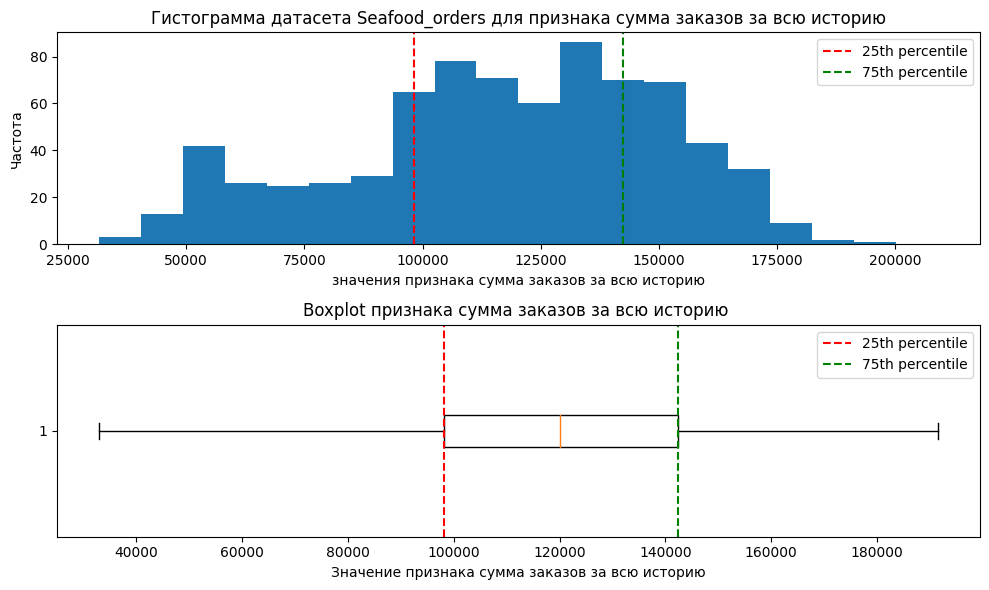

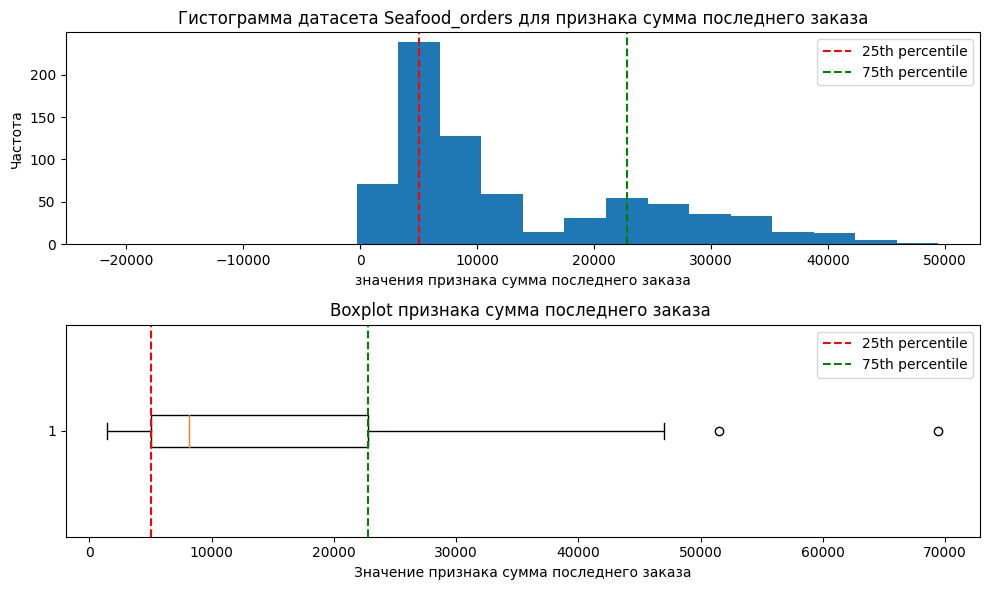

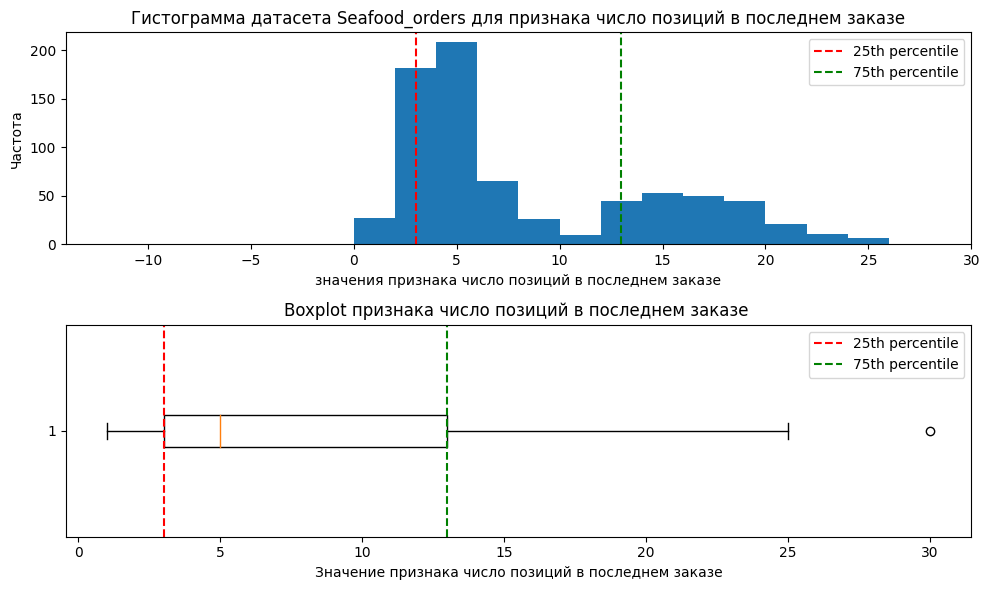

In [11]:
for col in numeric_columns:
    hist_boxplot(data=data, col=col, dataset_name ='Seafood_orders', dict_names=dict_names)

Функция для построения столбчатых диаграмм для категориальных признаков

In [12]:
def bar_plot(data, col, dataset_name, dict_names):
    try:
        data[col].value_counts().plot(kind='bar', legend=True, figsize=(10,5))
        plt.title(f'Диаграмма частоты признака {dict_names[col]} датасета {dataset_name}')
        plt.xlabel(f'значение признака {dict_names[col]}')
        plt.ylabel(f'Частота признака {dict_names[col]}')
        plt.show()
        
    except KeyError:
        print(f'Признак {dict_names[col]} не может быть описан столбчатоый диаграммой')

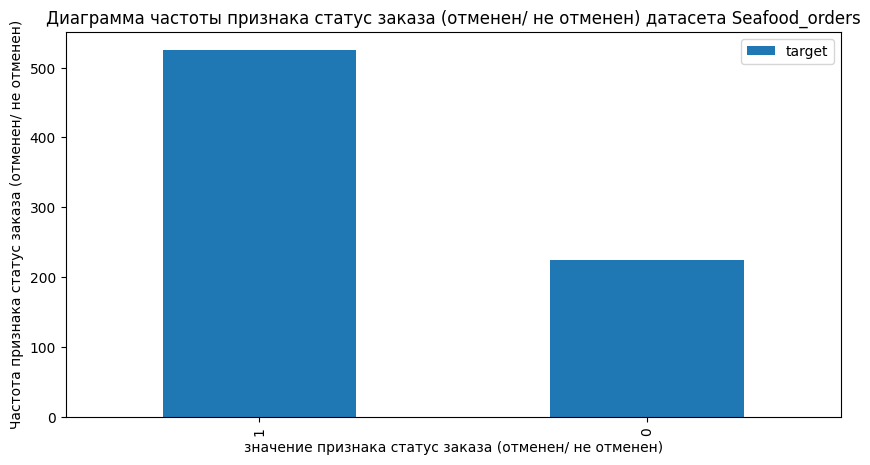

In [13]:
for col in categorical_columns:
    bar_plot(data=data, col=col, dataset_name='Seafood_orders', dict_names= dict_names)

### Работа с моделью линейной регрессии

#### Подготовка данных и Обучение модели

In [14]:
RANDOM_STATE = 77

X = data.drop(columns=['target', 'client_id'])
y = data['target'] 

scaler = StandardScaler()

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
X_train_scalled = scaler.fit_transform(X_train)
X_test_scalled = scaler.transform(X_test)

clf = LogisticRegression()
clf = clf.fit(X_train_scalled, y_train)
y_pred = clf.predict(X_test_scalled) 


r = accuracy_score(y_test, y_pred)

print(r)

0.648936170212766


А вдруг точности в 65% достаточно, чтобы выполнить запрос бизнеса и сэкономить 1 млн 100 тыс. рублей? 

Для проверки предлагаем сделать приблизительный расчёт на тестовой выборке: 
1) Сначала вычислить, сколько компании удалось бы сберечь благодаря модели. Для этого нужно умножить стоимость отменённых заказов, которые удалось предсказать, на 70% — размер предоплаты. Но важно учесть, что 20% клиентов из-за нового требования изначально не оформили бы заказ — соответственно, предоплату не внесли бы. Поэтому рассчитанную сумму выгоды нужно умножить ещё и на 80%, чтобы её уточнить. То есть слегка уменьшить.

2) Потом найти сумму, которую компания потеряла бы из-за модели. Чтобы её выяснить, тоже важна статистика об уходе пятой части клиентов из-за запроса на предоплату. Надо умножить на 20% стоимость заказов, отмена которых не подтвердилась. Ведь их могли бы оплатить, если бы никого не смутило новое требование.
3) Вычесть из сбережённой суммы объём потерь.

In [15]:
predicts = X_test[['summ_']]
predicts['y_pred'] = y_pred
predicts['y_test'] = y_test

TP = predicts.loc[(y_pred==1)&(y_test==1), 'summ_'].sum()*0.7*0.8
FP = predicts.loc[(y_pred==1)&(y_test==0), 'summ_'].sum()*0.2

money = TP-FP
print(money)

1066557.42


/var/folders/9t/0d2y6zvs0pn1b5hks81yn5jw0000gn/T/ipykernel_7216/3228329572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicts['y_pred'] = y_pred
/var/folders/9t/0d2y6zvs0pn1b5hks81yn5jw0000gn/T/ipykernel_7216/3228329572.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicts['y_test'] = y_test


Результат: с нынешней моделью для наблюдений тестовой выборки получилось сэкономить около 1 млн 66 тыс. рублей. Чтобы окупить расходы на внедрение машинного обучения, надо «выиграть» больше.

#### Настройка модели с помощью порогов

In [16]:
import numpy as np

thresholds = [round(i,2) for i in np.linspace(0.1,1,num = 12,endpoint=False)]
y_proba_log = clf.predict_proba(X_test_scalled)[:,1]

for i in thresholds:
    y_pred_log = []
    for j in y_proba_log:
        if j<i:
            y_pred_log.append(0)          
        else:
            y_pred_log.append(1) 
    predicts = pd.DataFrame(zip(y_pred_log, y_test,  X_test['summ_'].tolist()), \
                        columns = ['y_pred', 'y_test', 'summ_'])
    TP = predicts[(predicts['y_pred']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
    FP = predicts[(predicts['y_pred']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2
    money = TP-FP
    print('threshold: ', i, '   money: ',money)

threshold:  0.1    money:  1089660.98
threshold:  0.18    money:  1089660.98
threshold:  0.25    money:  1089660.98
threshold:  0.32    money:  1089660.98
threshold:  0.4    money:  1087737.372
threshold:  0.48    money:  1080149.3480000002
threshold:  0.55    money:  1049577.9239999999
threshold:  0.62    money:  1022793.4440000001
threshold:  0.7    money:  982374.764
threshold:  0.77    money:  941061.4520000002
threshold:  0.85    money:  858757.1720000001
threshold:  0.92    money:  574174.244


#### Так в чем же дело?

В датасете есть выбросы — не аномальные, но нестандартные комбинации входных и целевых признаков. 

Посмотрим на график зависимости целевого признака от входных, разбитых по парам. 

На нём видно, как распределились отменённые и подтверждённые заказы при разных значениях входных признаков. 

Как видите, ни на одном из изображений нет чёткой границы между отменёнными заказами — оранжевыми кружками — и подтверждёнными — кружками синими. Каждый синий кружок среди большого количества оранжевых — и наоборот — это и есть свидетельство нестандартной комбинации признаков. Необычные значения целевого признака, которые мешают линейной модели учиться. И которые сложно предсказать.

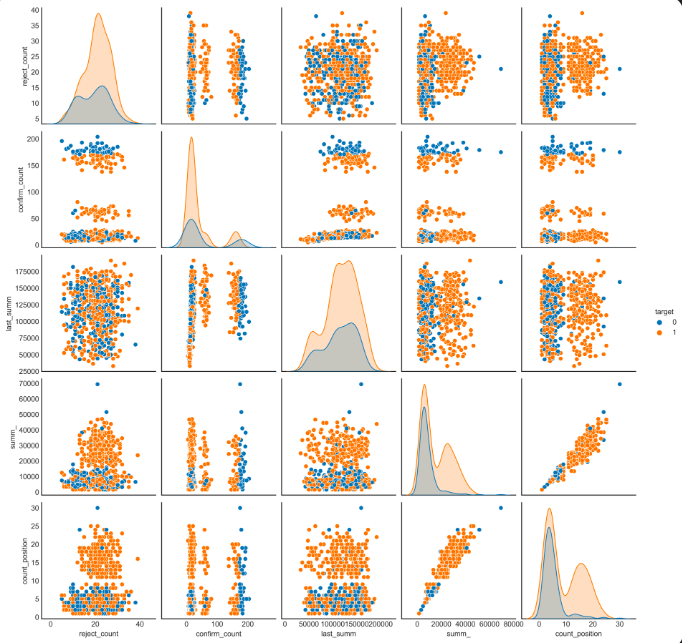

Строим scatter matrix в библиотеке seaborn с заголовком + выводим без дурацкой текстовой строки сверху

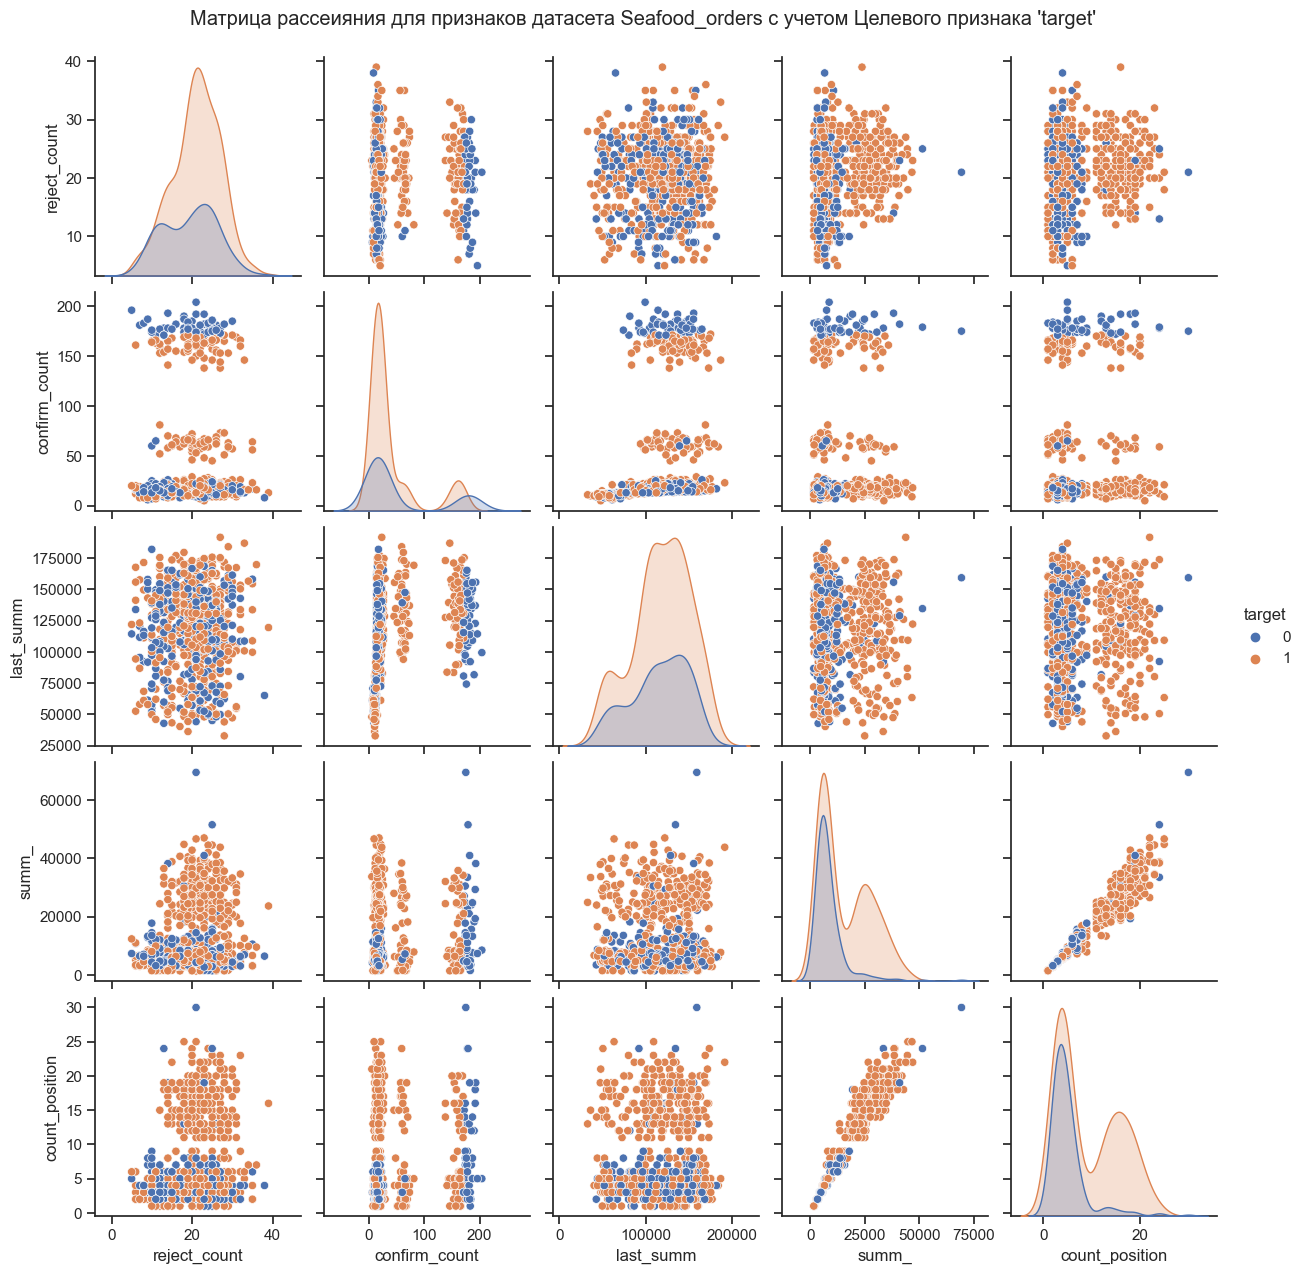

In [17]:

sns.set_theme(style="ticks")

sns.pairplot(data.drop('client_id', axis=1), 
             hue="target")


plt.suptitle(f"Матрица рассеияния для признаков датасета Seafood_orders с учетом Целевого признака 'target' ",
             y = 1.02)

# Показываем график
plt.show()

Удалять аномальные выбросы нельзя, ведь заказчик попросил учесть информацию о нестандартных клиентах и заказах, чтобы делать предсказания в разных ситуациях.

#### Выводы
Линейная и логистическая регрессии хорошо работают на данных с сильной <font color='red'>линейной зависимостью</font>  между целевым и входными признаками.

Нужно использовать другую модель классификации

### Урок 1. Модель «Метод опорных векторов»

#### Базовое понятие

Что такое выброс и что аномалия?

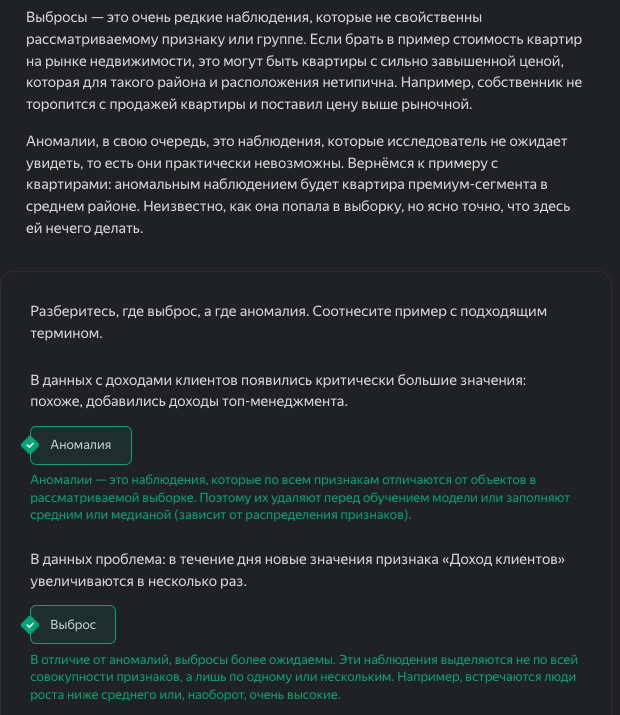

Понятие метода опорных векторов

Вернёмся к проблеме с моделями. Напомним: логистическая регрессия не справляется с классификацией из-за выбросов. Поэтому специалисты по DS придумали строить прямую не ближе всего к точкам наблюдений, а как можно дальше от границ двух классов. Получилась робастная модель под названием «Метод опорных векторов» (англ. support vector machine, SVM). 

Другой принцип обучения позволяет этой модели обходить выбросы стороной — буквально.

Построить прямую подальше от границ разных классов — значит провести её с максимальным зазором между крайними точками каждого из них:

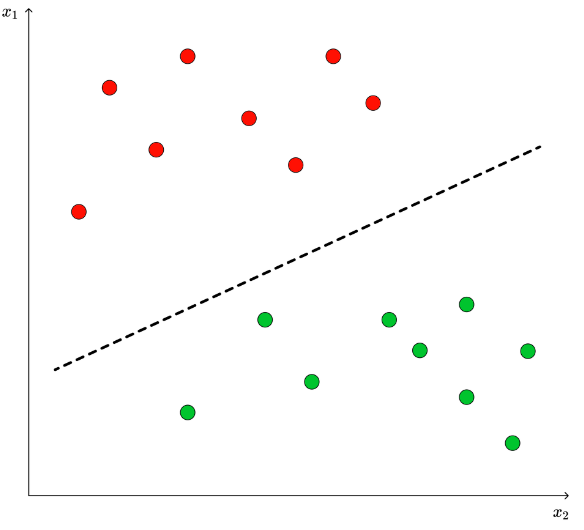

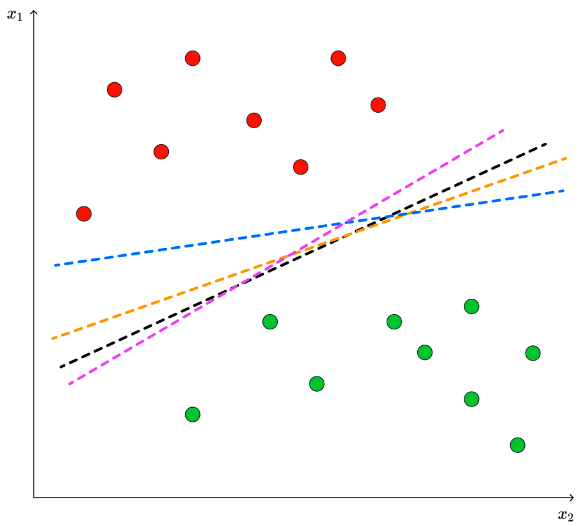

Выбор прямой, разделяющей классы

Лучшей среди прямых будет та, что находится на одинаково максимальном расстоянии между двумя классами. Определить это расстояние, или зазор, помогут ближайшие к «спорной» зоне точки-наблюдения из обоих классов.

        Их называют опорными векторами, благодаря им модель и получила своё название.


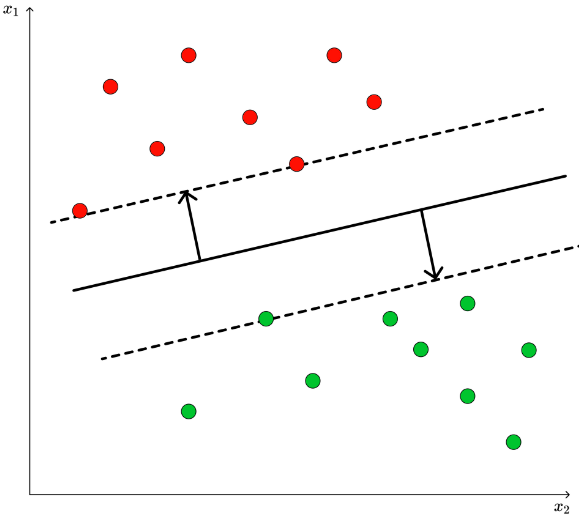

Выбор наилучшего варианта проведения прямой (или гиперплоскости)

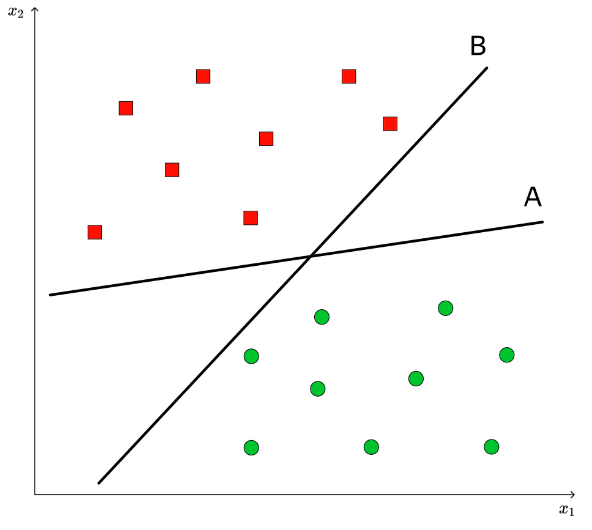

        лучше вариант A. 

Чтобы хорошо разграничить классы, между гиперплоскостью и каждым из классов должно быть как можно больше места. Так модель будет реже ошибаться с новыми наблюдениями, которые могут выйти за узкие рамки и ошибочно залезть на территорию другого класса. 

Этим SVM отличается от логистической регрессии — <font color='red'>логрег подстраивается под каждое наблюдение, а не под класс в целом.</font> 

#### Математическая основа метода опорных векторов

Принцип работы 

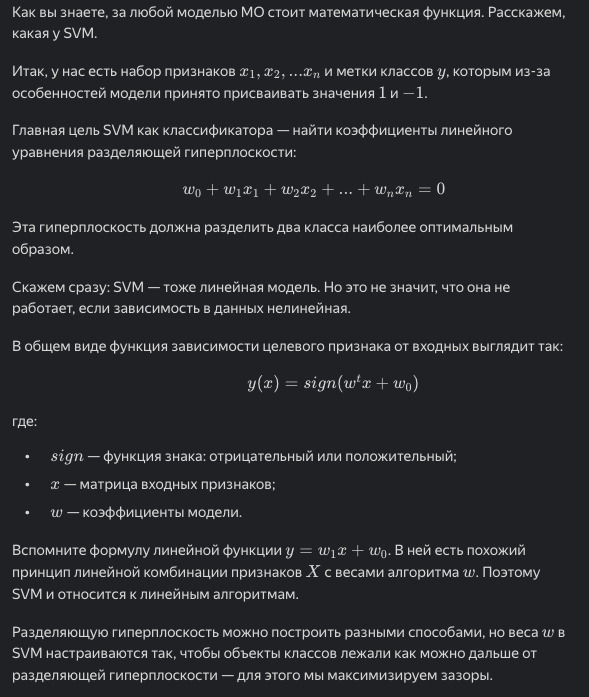

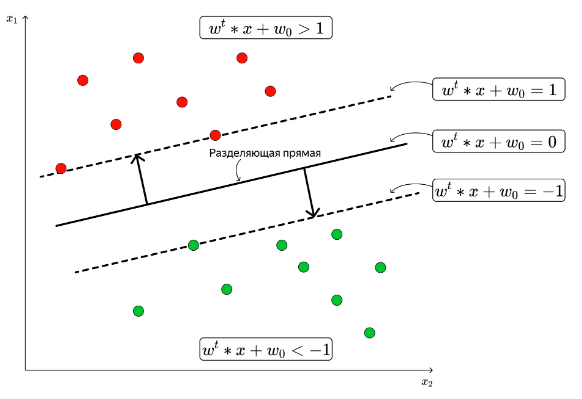

Итак, для решения задачи нужно, чтобы выполнялись два условия: 
- Прямая (или гиперплоскость) должна разделять классы как можно лучше, то есть расстояния от прямой до классов должны быть максимальными.

- Модель должна ошибаться как можно реже или не ошибаться вовсе (в лучшем случае).

Максимизируем зазор

Чтобы задать максимальный зазор, нужно посчитать расстояние от опорной точки-наблюдения до разделяющей прямой.

Напомним определение:

Расстояние от точки до прямой — это длина перпендикуляра, опущенного из этой точки на прямую.

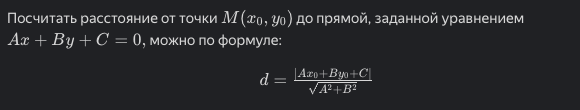

Поиск ширины "зазора" для общего случая

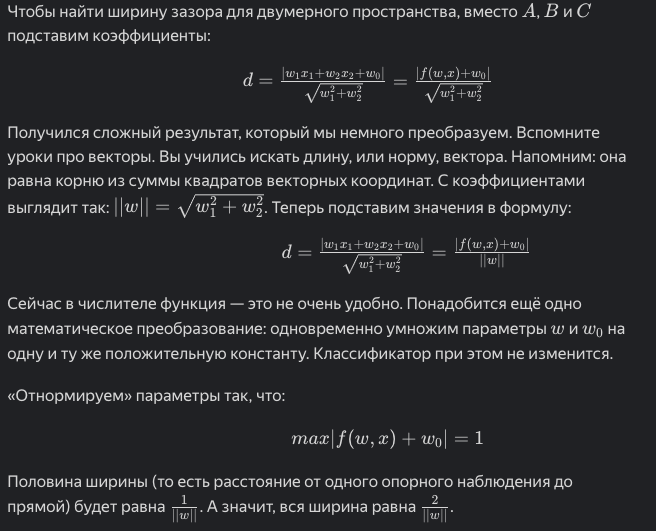

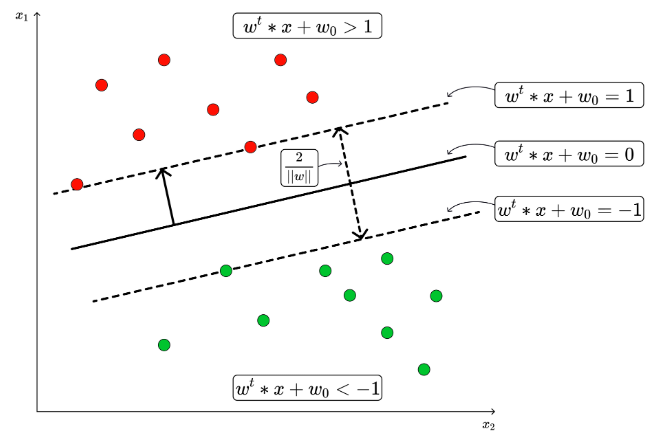

Цель - сделать зазор максимальным:

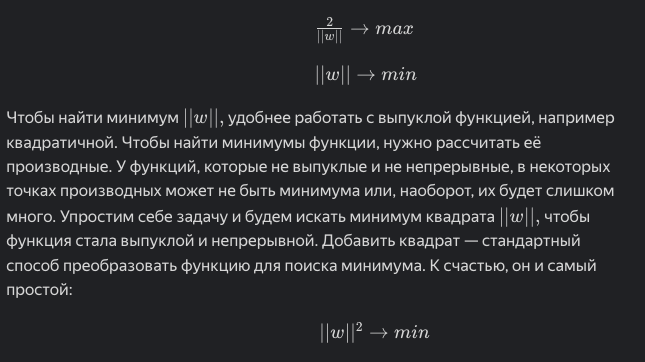

Работаем с ошибками модели

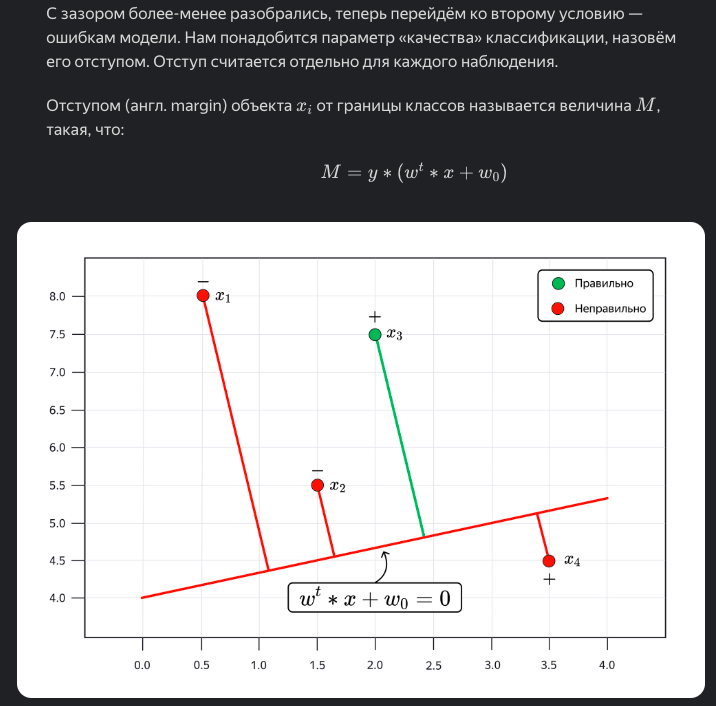

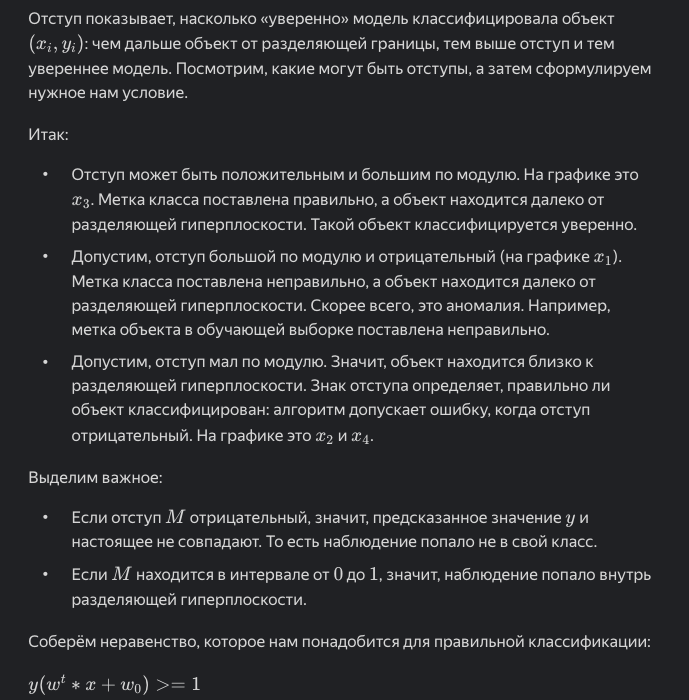


<font color='red'>
Выделим важное:

- Если отступ 
M отрицательный, значит, предсказанное значение 
y и настоящее не совпадают. То есть наблюдение попало не в свой класс.

- Если 
M находится в интервале от 
0 до 
1, значит, наблюдение попало внутрь разделяющей гиперплоскости.

</font>

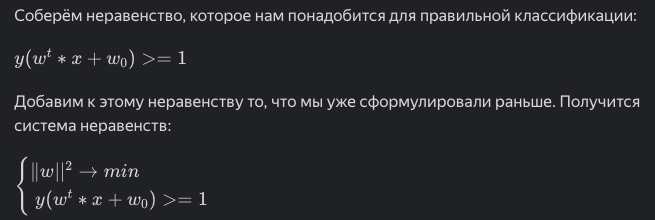

Что делать, когда данные точно не разделятся идеально?

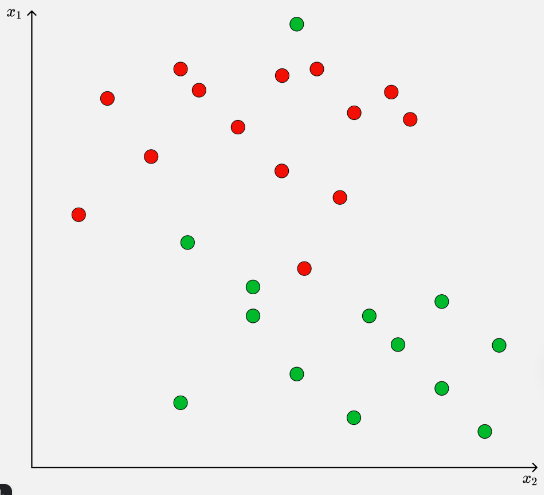

Нужно признать, что алгоритм будет ошибаться. Текущая система неравенств не допускает таких ошибок, ведь отступ всегда должен быть больше одного или равен одному. Позволим модели допускать ошибки, но сделаем так, чтобы их было как можно меньше.

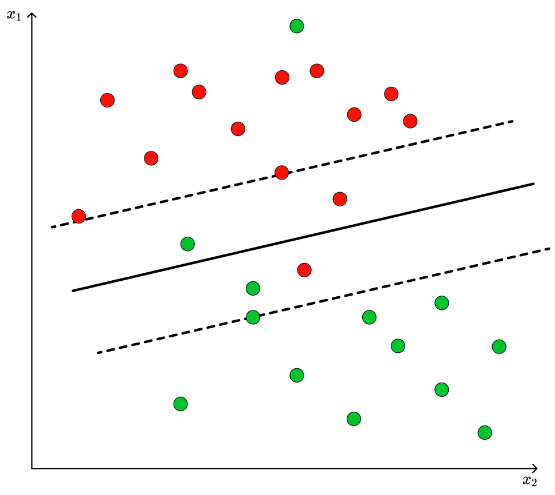

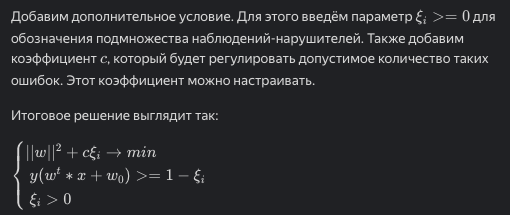

Такой зазор называют «мягким» (англ. soft margin). Он зависит от количества объектов-нарушителей: чем больше нарушителей мы допускаем, тем шире зазор, но больше ошибок при обучении. Широкий зазор строят в случае, когда данные сложно разделить линейно. Он помогает модели быть менее чувствительной к выбросам.

Выводы
- Логистическая регрессия не может работать с выбросами: она «подстраивается» под все данные, и потому при наличии выбросов решение будет сдвинуто в сторону неверных наблюдений.

- Бывает, что выбросы удалить невозможно. Тогда используют другие модели классификации, например метод опорных векторов.
Принцип работы метода такой — максимизировать расстояние между классами, проводя разделяющую прямую или гиперплоскость.

####  Метод опорных векторов python (SVM в scikit-learn)

Вернемся к данным по ресторану морепродуктов

In [18]:
data.head()

client_id  reject_count  confirm_count  last_summ    summ_  count_position  \
0       8195            27             13   132684.4  34875.3              18   
1      16392            29             15   149790.1  19537.4              11   
2      16396            25             17    80195.2  44583.0              23   
3       8206            22             10    80089.5  22561.6              15   
4      16398            14             14   163565.6  27986.4              17   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

Модель SVC (от англ. support vector classification — «классификация опорных векторов») используется для задач классификации. 

Получается, что есть и другая? Да, SVR (от англ. support vector regression — «регрессия опорных векторов»). 

Последнюю мы пока рассматривать не будем, ведь для нашей задачи нужна именно SVC.

In [19]:
from sklearn.svm import SVC

clf = SVC()

X = data.drop(columns=['target', 'client_id'])
y = data['target']

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
X_train_scalled = scaler.fit_transform(X_train)
X_test_scalled = scaler.transform(X_test)

clf = SVC()

clf.fit(X_train_scalled, y_train)
y_pred = clf.predict(X_test_scalled)

r = accuracy_score(y_test, y_pred)
print(r)

0.7180851063829787


Качество модели Метода опорных векторов выше - у логистической регрессии точность была 0.65

Теперь считаем потерянные деньги

In [20]:
# создаём таблицы для подсчёта средств, которые удалось сэкономить
predicts = X_test[['summ_']].copy()
predicts['SVM'] = y_pred
predicts['y_test'] = y_test

TP = predicts.loc[(y_pred==1)&(y_test==1), 'summ_'].sum()*0.7*0.8
FP = predicts.loc[(y_pred==1)&(y_test==0), 'summ_'].sum()*0.2

money = TP-FP
print(money)

1111647.992


Логрег позволяла экономить 1 089 660.98 руб при настройке порогов , а Метод опоорных векторов - 1,11 млн

В точности мы действительно выиграли

####  Построение гиперплоскости

In [21]:
# ставим библиотеку для построения гиперплоскости
# !pip3 install mlxtend

In [22]:
# Импортируем функцию plot_decision_regions, которая отрисует разделяющую границу:

from mlxtend.plotting import plot_decision_regions 

In [23]:
# поставить модуль в нужную версию python - через консоль!!!
#python3.10 -m pip install mlxtend

In [24]:
# посмотреть все модули , посмотреть все пакеты, которые установлены в python
# но запускать отдельной строкой!!!! без комментариев!!!

# pip freeze


Строим схему разделения и оцениваем как классификатор принимает решение по классификации


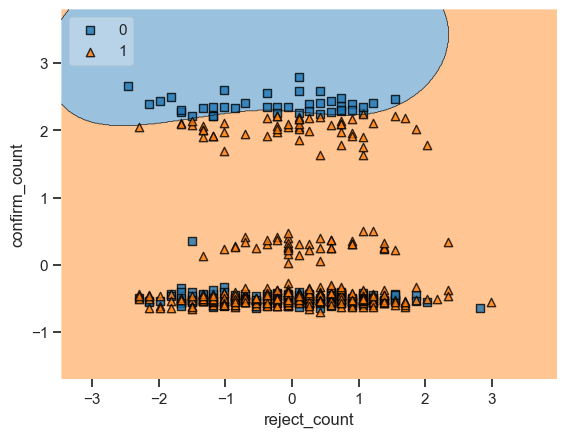

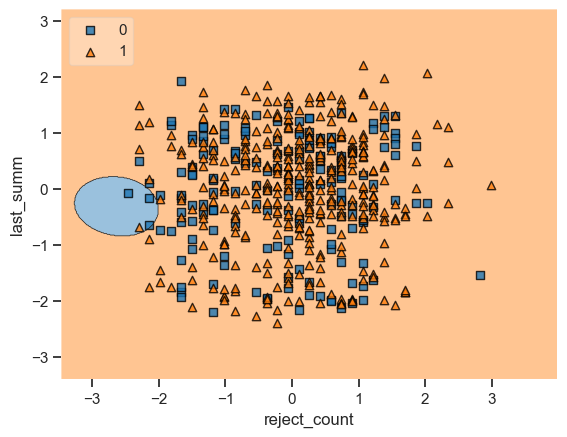

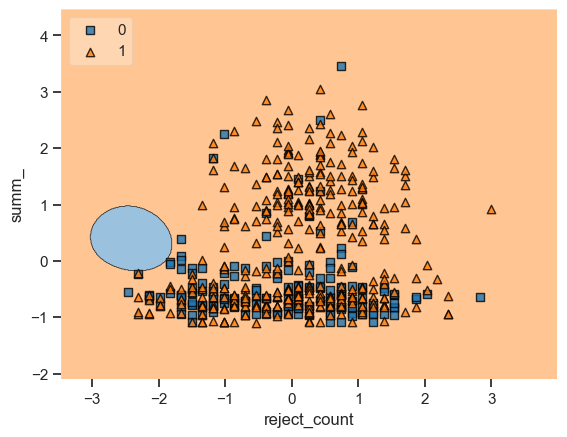

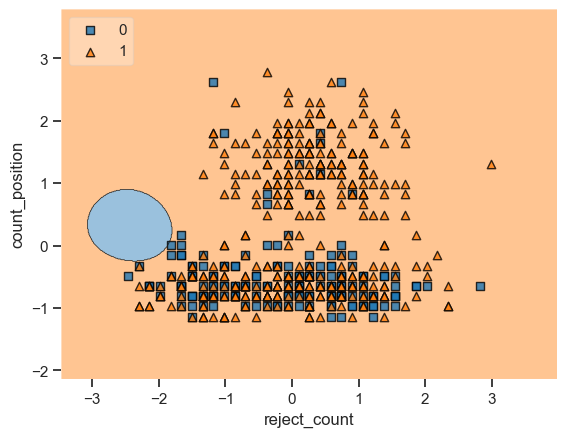

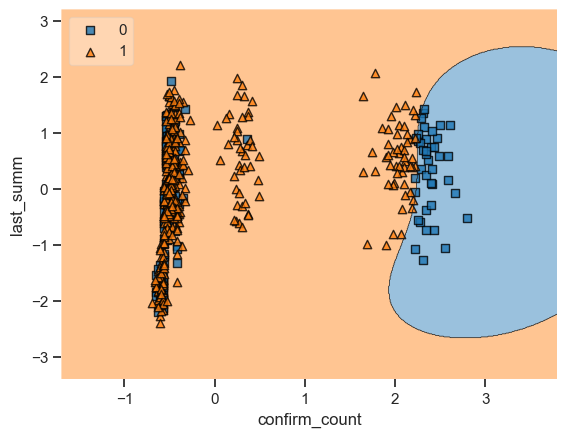

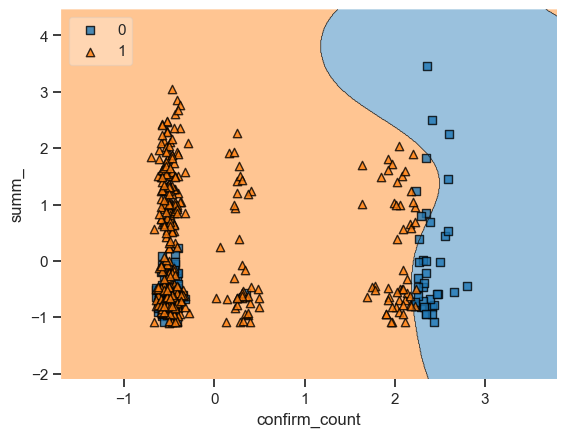

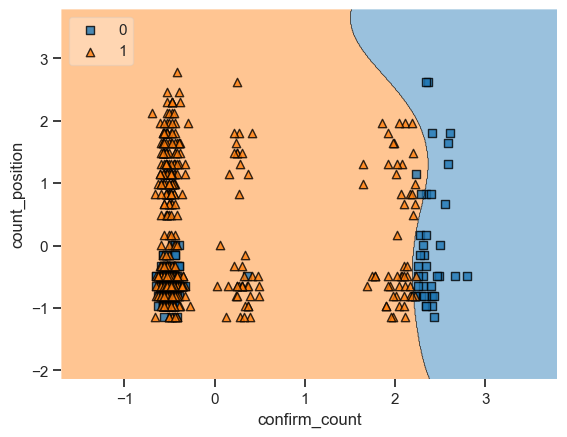

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mlxtend/plotting/decision_regions.py:315: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels, **contour_kwargs)


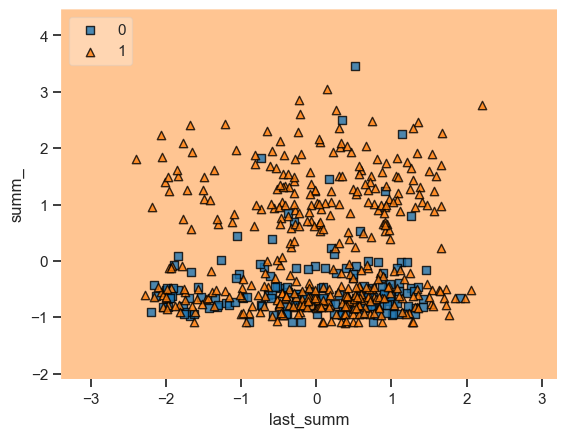

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mlxtend/plotting/decision_regions.py:315: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels, **contour_kwargs)


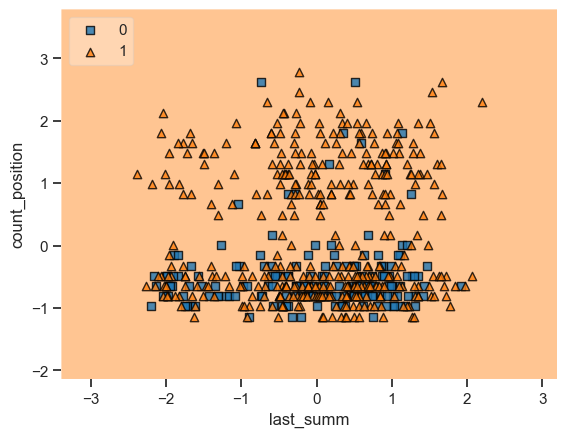

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mlxtend/plotting/decision_regions.py:315: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels, **contour_kwargs)


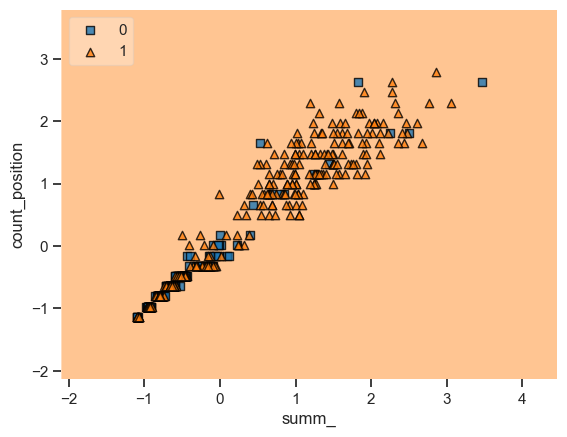

In [25]:
from itertools import combinations

# генерируем варианты разбивки признаков на пары без повторений
columns = list(X_train.columns)
all_variants = list(combinations(columns, 2))

# создаём и обучаем модель — она обучается на паре признаков и строит 
# для них разделяющую границу
for i in range(len(all_variants)):
    model = SVC()
    X_new_train = X_train[[all_variants[i][0], all_variants[i][1]]]
    X_new_scalled = scaler.fit_transform(X_new_train)
    model.fit(X_new_scalled, y_train)
    a = plot_decision_regions(X_new_scalled, y_train.to_numpy(), clf=model, legend=2)
    plt.xlabel(all_variants[i][0])
    plt.ylabel(all_variants[i][1])
    plt.show()

Почему модель линейная, а границы — совсем не линейные.
?

#### Настройки SVM

##### Kernel 

kernel - внутренняя настройка, которая отвечает за вид разделяющей границы модели SVM 

В нашем случае данные нельзя разделить линейно. Поэтому если модель может подобрать нелинейную разделяющую границу, то она лучше справится с предсказанием. 

Пример - как разделить данные, связанные явно нелинейно?

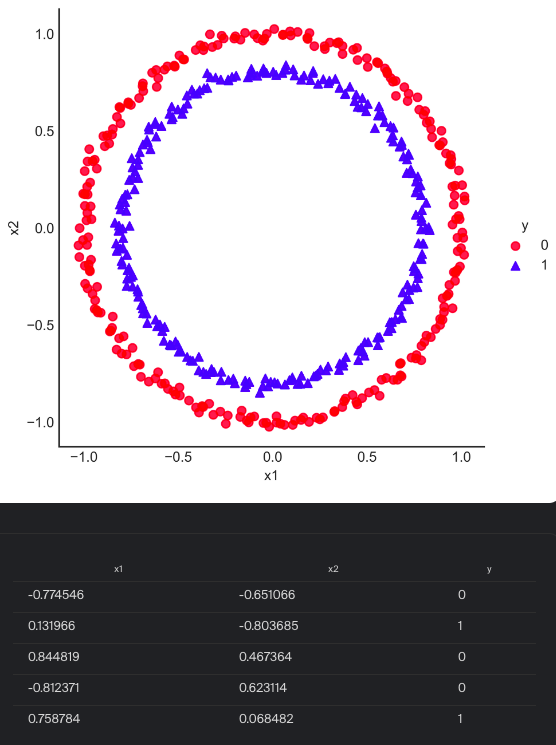

Данные связаны нелинейно. Добавим новую переменную, чтобы перейти в пространство большей размерности, например в трёхмерное. Сделаем это и добавим новую переменную. Она «искривит» расположение наблюдений.

Добавить переменную можно разными способами. Чтобы не потерять зависимости от существующих переменных, сделаем третью функцией от первых двух:

x3 = (x1**2 + x2**2) 

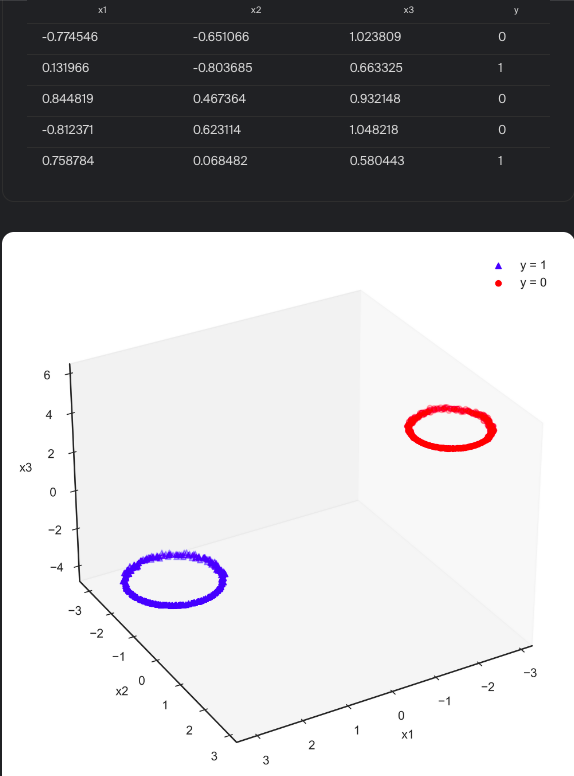

Теперь провести границу легко - это плоскость между двумя классами наблюдений

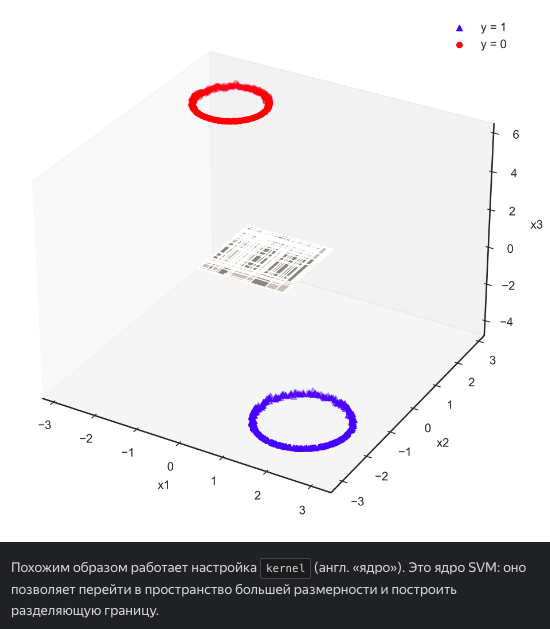


Что такое Ядра?

Ядра — это математические функции. Их используют, чтобы проецировать данные в многомерное пространство, в котором может быть легче найти хорошую границу принятия решения. Это полезно, ведь данные часто нельзя разделить линейно, а значит, нельзя легко классифицировать с помощью прямой линии или гиперплоскости. Благодаря ядрам SVM может находить нелинейные границы — так сложные данные будут классифицироваться точнее.

Расскажем, какие бывают ядра. Осторожно: ниже несколько сложных терминов и уравнений. Не переживайте, если поймёте не всё: подбирая ядра, специалисты часто ориентируются на качество решения, а не на принципы, которые стоят за разными ядрами. Несколько рекомендаций о выборе ядер мы всё-таки дадим — ищите их в конце урока.

Линейное ядро

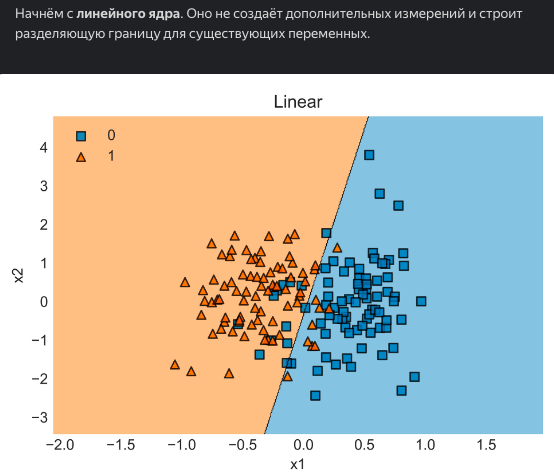

Ядро радиальной функции

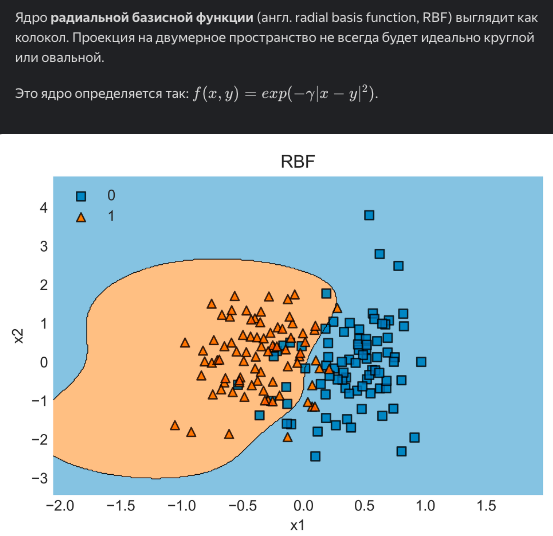

Сигмоидное ядро

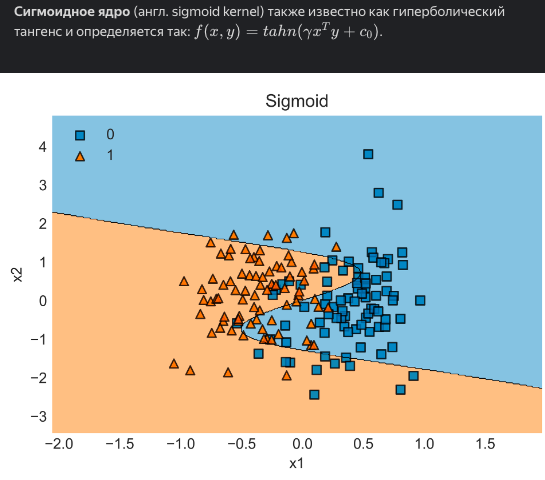

Полиамиальное ядро

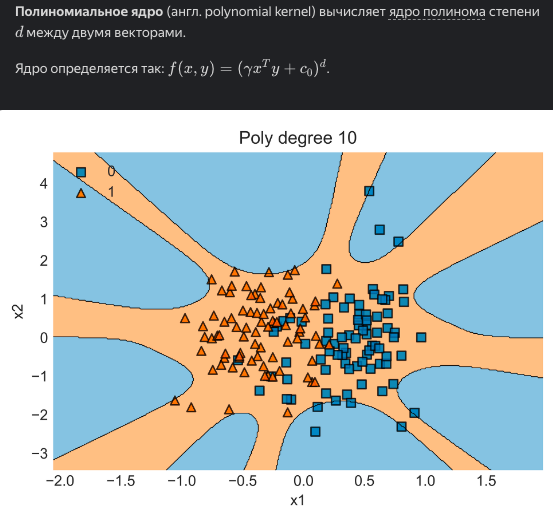

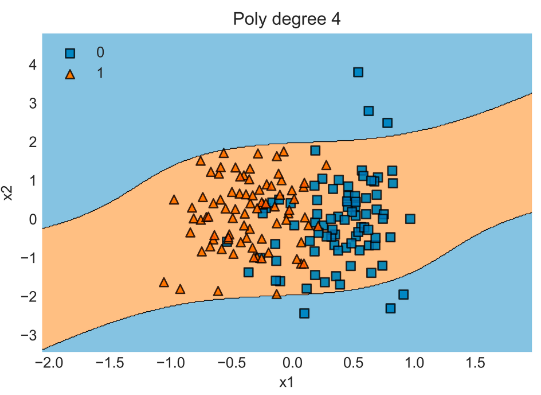

Собственная функция ядра (пользовательская)

Ядро 'precomputed' — собственная функция ядра, её задаёт пользователь самостоятельно. 

Какое ядро использовала модель при построении гиперплоскости?

Возвращаемся к графикам построения гиперплоскости для ресторана морепродуктов

Модель применила значение kernel по умолчанию: 'rbf' (ядро радиальной функции) именно поэтому модель построила нелинейную границу и справилась лучше, чем логистическая регрессия.

Что будет, если применить линейное ядро для Метода опорных векторов?


In [27]:
clf = SVC(kernel = 'linear')
clf.fit(X_train_scalled, y_train)
y_pred = clf.predict(X_test_scalled)
r = accuracy_score(y_test, y_pred)
print(r)

0.6914893617021277


In [28]:
predicts = X_test[['summ_']].copy()
predicts['SVM'] = y_pred
predicts['y_test'] = y_test
TP = predicts[(predicts['SVM']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
FP = predicts[(predicts['SVM']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2
print(TP-FP)

1089660.98


Качество упало, экономия - та же, что и у логрег

Попробуем другие настройки ядра

In [43]:
# сигмоидное ядро
# объявляем классификатор и обучаем модель
clf_sigm = SVC(kernel='sigmoid')
clf_sigm.fit(X_train_scalled, y_train)
y_pred_sigm = clf_sigm.predict(X_test_scalled)
r = accuracy_score(y_test, y_pred_sigm)
print(r)

0.601063829787234


In [44]:
# полинамиальное ядро с 6 степенями
# объявляем классификатор и обучаем модель
clf_poly = SVC(kernel='poly', degree = 6 )
clf_poly.fit(X_train_scalled, y_train)
y_pred_poly = clf_poly.predict(X_test_scalled)
r = accuracy_score(y_test, y_pred_poly)
print(r)

0.723404255319149


In [45]:
predicts = X_test[['summ_']].copy()
predicts['SVM'] = y_pred_poly
predicts['y_test'] = y_test
TP = predicts[(predicts['SVM']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7**0.8
FP = predicts[(predicts['SVM']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2
print(TP-FP)

1525373.848445396


Итог работы разных ядер в нашей задаче:

- Линейное ядро справилось не лучше логистической регрессии.

- Сигмоидное ядро показало себя ещё хуже.

- Ядро 'rbf' помогло достичь желаемого результата, но ядро полинома 6-й степени справилось лучше всех.

Настройка модели — важный этап в машинном обучении. Чем сложнее модель, тем больше у неё своеобразных ручек и переключателей, которые можно «подкрутить».

#### Проверка качества SVM

Используем дополнительные данные, которые только что поступили

In [48]:
test_data = pd.read_csv('orders_seafood_test.csv')

In [49]:
# импортируем необходимые библиотеки и объявляем константы
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
scaler = StandardScaler()

RANDOM_STATE = 77

data = pd.read_csv('orders_seafood.csv')

X = data.drop(columns=['target', 'client_id'])
y = data['target']

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

X_train_scalled = scaler.fit_transform(X_train)
X_test_scalled = scaler.transform(X_test)

# объявляем классификатор и обучаем модель

clf_poly = SVC(kernel = 'poly', degree = 6)
clf_poly.fit(X_train_scalled, y_train)

# работаем с дополнительным датасетом

test_x = test_data.drop(columns=['client_id', 'target'])
test_y = test_data['target']
test_data_scalled = scaler.transform(test_x)

y_pred_poly_test = clf_poly.predict(test_data_scalled)

r_poly = accuracy_score(test_y, y_pred_poly_test)
print(r_poly)

0.59


In [50]:
predicts = test_x[['summ_']].copy()
predicts['SVM_poly'] = y_pred_poly_test
predicts['y_test'] = test_y
TP = predicts[(predicts['SVM_poly']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
FP = predicts[(predicts['SVM_poly']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2
print(TP-FP)

1059829.6119999997


Качество существенно упало и экономия в деньгах тоже(



Причина: Такое происходит, когда модель слишком сильно подстраивается под тренировочный набор данных и в итоге ошибается на тесте.

#### Отличия Логистической регрессии от Метода опорных векторов

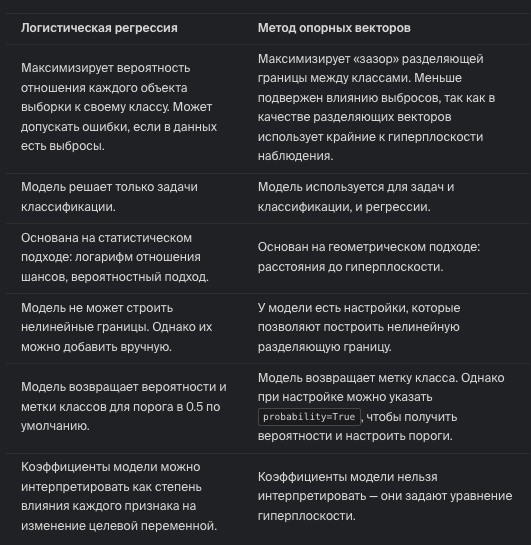

#### Выводы

- Метод опорных векторов — линейная модель. Тем не менее она может строить и нелинейные границы.

- Для этого нужны ядра — математические функции, которые «искривляют» пространство признаков.

- Бывает, что модель сильно подстраивается под данные. Тогда разница качества между тренировочными и тестовыми данными может быть огромной.

### Как выбрать подходящую модель классификации?


Зависит от исходных данных:
        n — количество признаков (столбцов); 
        m — количество обучающих данных (строк).

<font color='red'>Сценарий 1 </font>

- n велико (между 
1000–
10 000)
- m мало (между 
10–
1000), 

- лучше применять логистическую регрессию или метод опорных векторов (SVM) с линейным ядром.

<font color='red'>Сценарий 2 </font>
- n скромное (между 1–1000)
- m находится в промежутке между 
10-
10 000, 
- больше подойдёт метод опорных векторов (SVM) с нелинейным ядром (RBF, полиномиальным и т. д.).

<font color='red'>Сценарий 3 </font>
- n мало (1-
1000), 
- m велико (от 
50 000 до 
1 000 000 и выше), 

- лучше применять логистическую регрессию или метод опорных векторов (SVM) с линейным ядром, добавив перед этим дополнительные признаки вручную.

### Урок 2. Проблема переобучения 

Проблема: модель всё равно плохо классифицировала объекты из тестовых данных, потому что слишком «привыкла» к тренировочным и валидационным. 

Цель: исправить проблему, из-за которой метод опорных векторов плохо классифицировал наблюдения из новой выборки заказчика.

#### Переобучение и недообучение

Проблема на примере:

Общая картина распределения

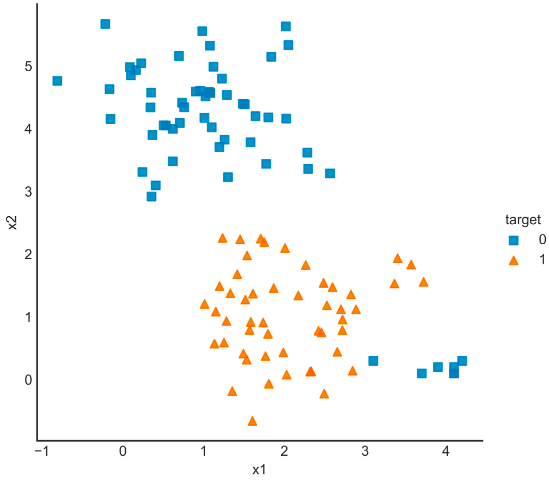

Работа модели с линейным ядром

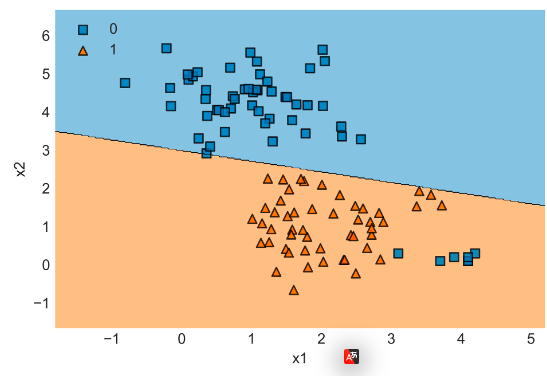

Работа модели с полиномиальным ядром в разно степени

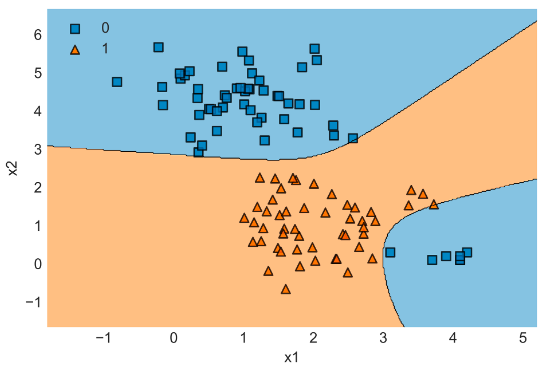

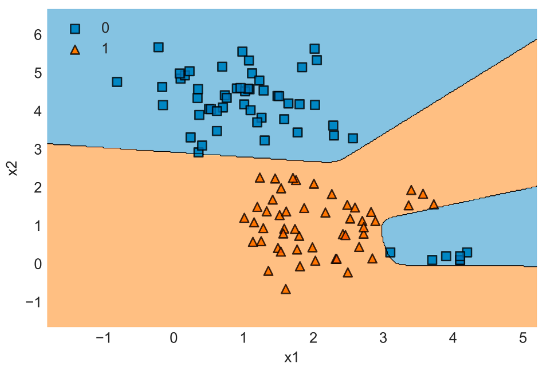

Ловушка в том, что хочется использовать максимально точную модель, которая безошибочно (почти) описала тренировочные данные.

Но тогда на тестовых модель покажет себя плохо - она слишком привыкла к тренировочным данным

Работа переобученной модели на тестовых данных

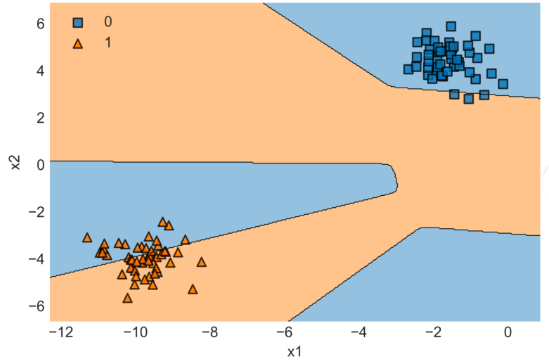

<font color='red'> SVM неверно классифицировала больше половины объектов класса 1! У модели с линейным ядром такой проблемы нет. </font>

Любые полиномиальные функции, в том числе и полученные с использованием ядра полинома, очень чувствительны к изменениям во входных признаках. Даже небольшие отклонения от привычных значений искажают результаты классификации. Чем выше степень, тем больше риск ошибок.

Работа недообученной модели на тестовых данных

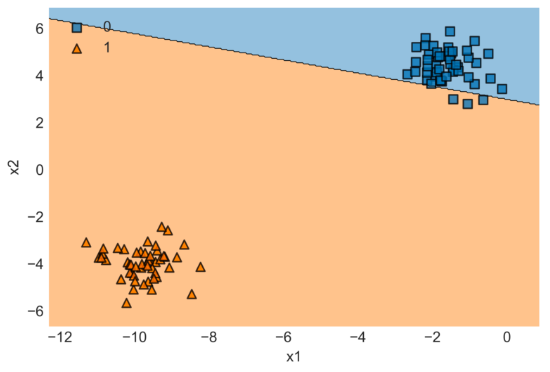

#### Исправление модели


Излишней подстройки модели под нетипичные наблюдения можно избежать, если выбрать более простое ядро или снизить степень ядра полинома. 

Достаточно взять робастное линейное ядро, оно проигнорирует выбросы, но в таком случае модель может совсем не уловить нужных закономерностей.

Задача: 

Возникает дилемма между точностью и гибкостью модели. Вам нужно <font color='red'>найти баланс — подобрать ядро, которое лучше опишет данные, но при этом не слишком сильно под них подстроится.</font>

Посмотрим на практике:

- Инициализируйте модель SVC с полиномиальным ядром степени 6. 
- Стандартизируйте тренировочные данные и обучите модель на признаках summ_ и confirm_count. Признаки уже отобраны в переменной columns. 
- Постройте разделяющую границу между классами функцией plot_decision_regions, передав ей нужные данные.

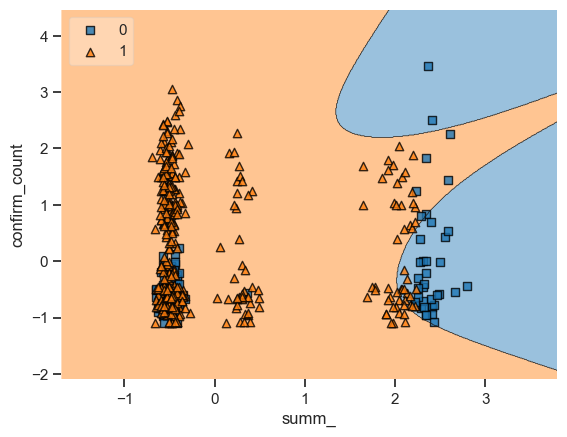

In [52]:
# импорт необходимых библиотек
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaler = StandardScaler()

# объявляем константу random_state
RANDOM_STATE = 77

# объявляем переменную с данными
# выделяем целевой и входные признаки
data = pd.read_csv('orders_seafood.csv')
X = data.drop(columns=['target', 'client_id'])
y = data['target']
columns = ['confirm_count','summ_']

# делим данные на тренировочные и валидационные
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
scaler = StandardScaler()

# инициализируйте модель SVM c ядром полинома степени 6
model = SVC(kernel='poly', degree = 6 )

# передайте признаки в тренировочную выборку и стандартизируйте их
X_new_train = X_train[columns]
X_new_scalled = scaler.fit_transform(X_new_train)

# обучите модель
model.fit(X_new_scalled, y_train)

# постройте разделяющую границу между классами
sns.set_style(style='white')
plot_decision_regions(X_new_scalled, y_train.to_numpy(), clf=model, legend=2)
plt.xlabel(columns[1])
plt.ylabel(columns[0])
plt.show()

Классификатор подстроился под два наблюдения класса 0 и теперь будет расценивать все наблюдения в верхнем правом углу таким же образом.


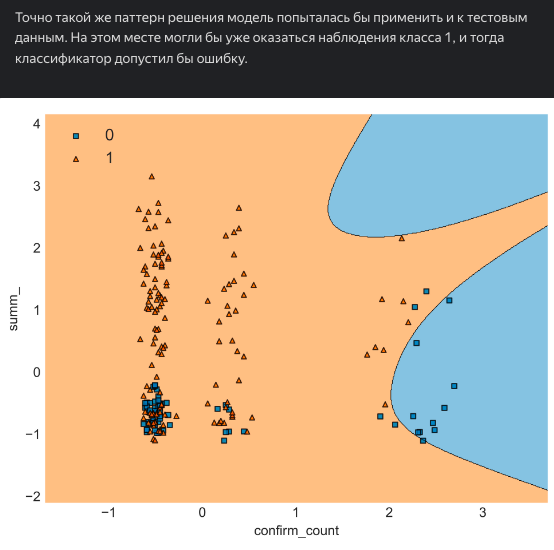

Это явный пример переобучения, который подрывает устойчивость модели. Её качество не должно сильно сокращаться во время классификации на новых данных с той же структурой. Чтобы проверить устойчивость, допустимо поменять разбивку данных новым значением <font color='red'>random_state</font>  и посмотреть, будет ли модель вести себя странно.

        Делайте новую разбивку, если подозреваете, что предыдущая плохо повлияла на обучение. Получившиеся изначально выборки могут сильно различаться, если вы работаете с вариативными данными. Лучше всего было бы расширить выборку новыми наблюдениями. Если это невозможно, меняйте разбивку и уменьшайте валидационную выборку.


        Будьте осторожны! Подгонять модель под все возможные варианты разбивки нельзя. Если модель слишком сильно зависит от разделения данных, то она не уловила все закономерности, и её нельзя использовать.

Как будем упрощать модель?

Самое простое, что можно сделать с переобученной моделью, — упростить её. В случае модели для «Морских вкуснях» стоит попробовать понизить степень ядра полинома и посмотреть на качество решения модели. Сделаем это в цикле:

In [53]:
for i in range(5):
    clf_poly = SVC(kernel = 'poly', degree = i+1)
    clf_poly.fit(X_train_scalled, y_train)
    y_pred_poly = clf_poly.predict(X_test_scalled)
    r = accuracy_score(y_test, y_pred_poly)
    print(i+1, r)

1 0.6914893617021277
2 0.7393617021276596
3 0.7127659574468085
4 0.7180851063829787
5 0.723404255319149


Разбивка тренировочных и валидационных данных

Оценим, как такое изменение модели повлияет на классификацию, если по-другому разбить данные на тестовые и валидационные.

In [56]:
# импорт необходимых библиотек
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

scaler = StandardScaler()

# объявляем константу random_state
RANDOM_STATE = 11

# объявляем переменную с данными
# выделяем целевой и входные признаки
data = pd.read_csv('orders_seafood.csv')
X = data.drop(columns=['target', 'client_id'])
y = data['target']

# делим данные на тренировочные и валидационные
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE )

# стандартизируем выборки
scaler = StandardScaler()
X_train_scalled = scaler.fit_transform(X_train)
X_test_scalled = scaler.transform(X_test)

# инициализируйте и обучите модель SVM
# с помощью цикла проверьте модель с несколькими степенями ядра полинома
# выведите accuracy для каждой итерации модели
for i in range(5):
    clf_poly = SVC(kernel = 'poly', degree = i+1)
    clf_poly.fit(X_train_scalled, y_train)
    y_pred_poly = clf_poly.predict(X_test_scalled)
    r = accuracy_score(y_test, y_pred_poly)
    print(i+1, r)


1 0.6861702127659575
2 0.7021276595744681
3 0.6808510638297872
4 0.6914893617021277
5 0.6861702127659575


Лучшая точность снова при степени 2

Проверим модель на тестовых данных

In [57]:
clf_poly = SVC(kernel = 'poly', degree = 2)
clf_poly.fit(X_train_scalled, y_train)

test_data = pd.read_csv('orders_seafood_test.csv')

test_x = test_data.drop(columns=['client_id', 'target'])
test_y = test_data['target']
test_data_scalled = scaler.transform(test_x)
y_pred_poly_test = clf_poly.predict(test_data_scalled)
r_poly = accuracy_score(test_y, y_pred_poly_test)
print(r_poly)

0.71


In [58]:
predicts = test_x[['summ_']].copy()
predicts['SVM_poly'] = y_pred_poly_test
predicts['y_test'] = test_y
TP = predicts[(predicts['SVM_poly']==1)&(predicts['y_test']==1)]['summ_'].sum()*0.7*0.8
FP = predicts[(predicts['SVM_poly']==1)&(predicts['y_test']==0)]['summ_'].sum()*0.2
print(TP-FP)

1410311.808


Результат достигнут!

#### Недообучение




Если слишком упростить модель, она не уловит закономерности и будет всегда плохо работать. Такую ситуацию называют недообучением.

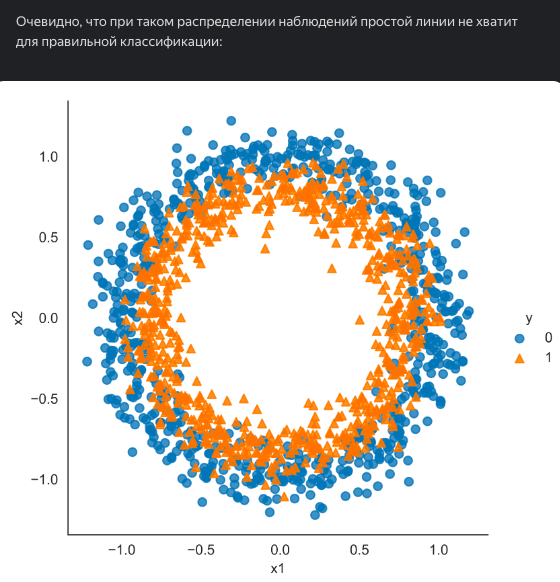

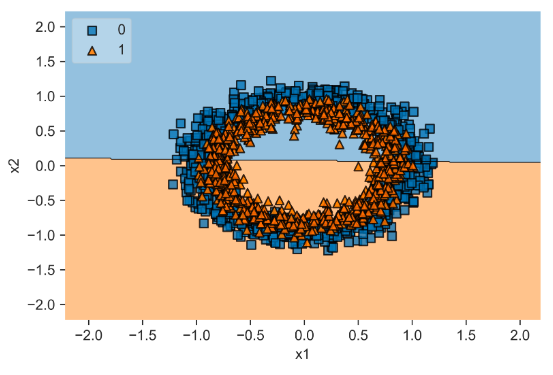

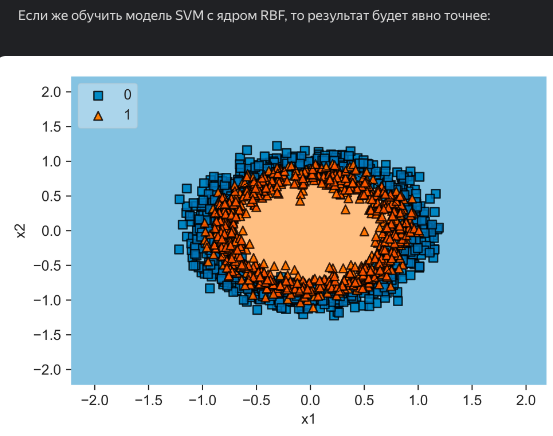

В отличие от переобучения, недообучение легко заметить в начале работы над моделью. Если она показывает низкое качество на тренировочных данных — куда ей работать с тестовыми!

Две крайности плохой работы модели, переобучение и недообучение, — это доказательство того, что во всём нужна золотая середина. Машинное обучение — не исключение.

#### Выводы по переобучению и недообучению 

- Переобучение — это ситуация, когда модель показывает высокое качество на тренировочных данных, но низкое на валидационных или тестовых.
- Обратная проблема — недообучение, когда модель плохо работает на любой выборке, потому что не уловила закономерности в данных.

- Чтобы избежать переобучения, используйте более простые модели. Но слишком сильно их упрощать нельзя: может возникнуть недообучение. Во всём важна золотая середина!

- Чтобы найти золотую середину, нужно проверять модель на разных данных. Для этого вы можете:
    - Поделить вашу исходную выборку на три, а затем сравнить результаты на валидационной и на тестовой.
    - Поменять константу random_state и посмотреть, есть ли взаимосвязь между разделением на выборки и качеством модели. Возможно, модель не улавливает всех закономерностей.

#### Регуляризация линейных моделей

Определение регуляризации

Регуляризация — это метод борьбы с переобучением, который добавляет дополнительные ограничения на модель за то, что она подстраивается под тренировочные данные. 

Что происходит в процессе регуляризации?

Регуляризация штрафует модель за то, как она подстраивается под данные, то есть влияет на коэффициенты модели. «Санкции» накладываются двумя способами, в зависимости от причин переобучения:

- Если модель чрезвычайно завышает важность признаков и плохо работает на валидационной или тестовой выборке, то регуляризация нужна, чтобы занизить коэффициенты модели.

- Иногда модель вообще зря считает признак значимым. Так бывает, если он вносит шум и усложняет модель без повышения её качества во время валидации или тестирования. Регуляризация будет «обнулять» веса таких признаков, чтобы модель их вовсе не учитывала.

##### Регуляризация линейной регрессии (L2-регуляризация)

Зачем?

модель склонна переоценивать веса признаков и может посчитать какой-то признак наиболее весовым, что приведет к ошибке на тестовых данных

Математическое описание метода

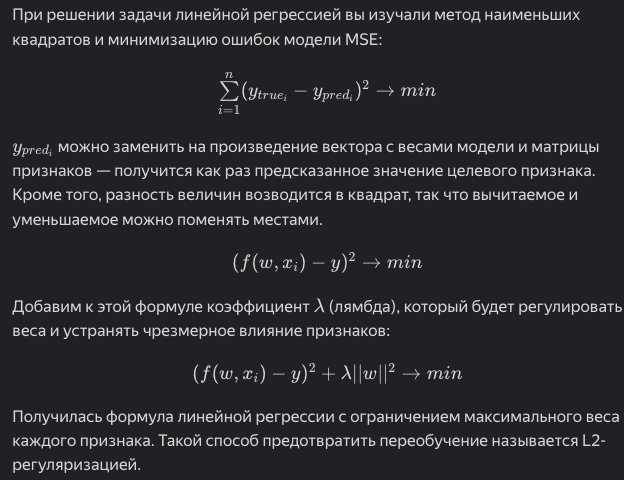

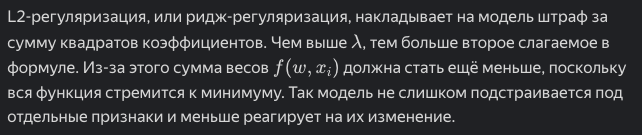

##### L1-регуляризация

Упростить модель можно иначе: не просто ограничить максимальный вес отдельных признаков, а совсем удалить неинформативные. Когда признаковое описание слишком большое и трудно оценить долю влияния каждого признака, используйте L1-регуляризацию, также известную как лассо-регуляризация.

Математическое описание работы

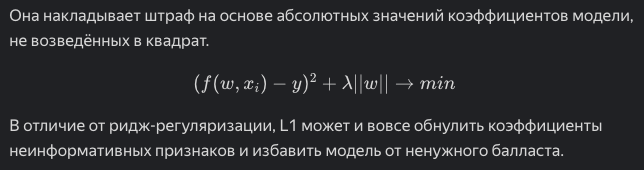

Трудно предугадать, какая из регуляризаций будет более эффективной, когда данных и признаков много. Изучать каждый признак долго и сложно, поэтому проще попробовать обе регуляризации и посмотреть, при какой из них выше качество на валидационной выборке.

##### Сравнительная таблица L1 и L2

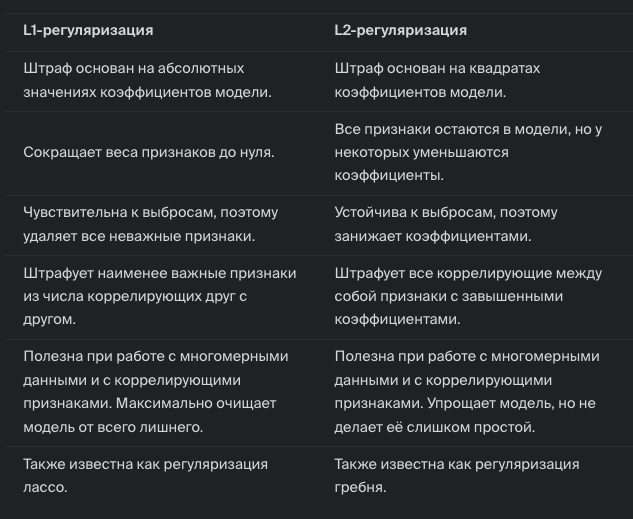

##### Выводы

- Регуляризация — это метод, который добавляет дополнительные ограничения на модель, чтобы предотвратить переобучение. Она накладывает штрафы на слишком высокие значения весов модели и снижает влияние некоторых признаков.
- L2-регуляризация уменьшает значения весов, чтобы сократить избыточное влияние входного признака на целевой.

- L1-регуляризация может обнулить веса, чтобы полностью устранить лишний признак из модели.
- Оба метода нужно проверять на конкретных данных, во время работы с валидационной выборкой.

#### Типы ошибок при моделировании


##### Смещение и разброс

Специалисту по Data Science нужно принять факт: модель всегда будет ошибаться. 100% верных ответов недостижимы. Если метрики показывают такое качество — это ошибка. Возможно, расчёты оказались неверными либо обучение и валидация прошли на той же выборке или на пересекающихся.

Формула ошибок алгоритма

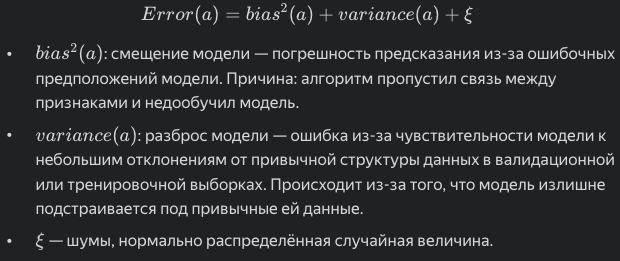

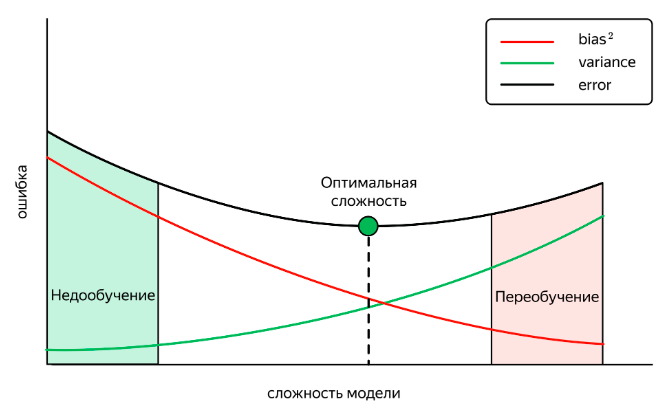

Если модель хорошо описывает тренировочные данные, то у неё низкое смещение, а если её предсказательные свойства высоки — у неё низкий разброс.

Задача

задача во время обучения модели — минимизировать ошибку так, чтобы значения метрик на тренировочных и валидационных данных практически не различались. 

Такое соотношение будет достигнуто у точки равновесия графиков смещения и разброса модели. Оба значения должны быть настолько низки, что нельзя ещё сильнее понизить одно без повышения другого. 

Если не найти равновесие, то модель:
- будет хорошо работать только на тренировочных данных — то есть переобучится;

- не уловит закономерности и будет всегда работать плохо — то есть недообучится.

Пример смещения и заброса

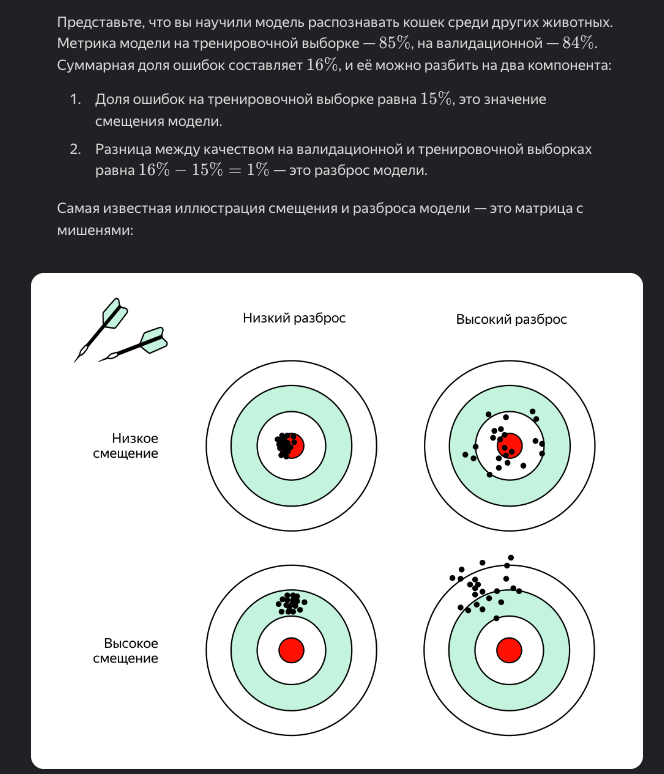

Пример смещения и разброса 2

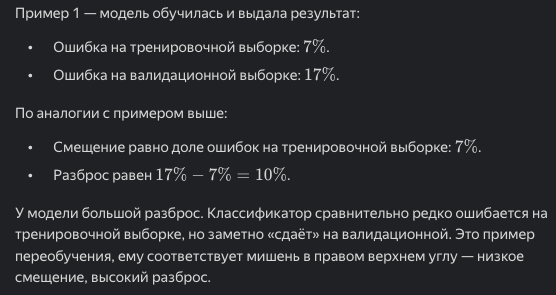

Пример смещени и разброса 3

У модели 2, точность которой на тренировочной выборке составила 
75%, а на валидационной — 
74
%

Смещение — 
25%, разброс — 
1%.

Этот классификатор недостаточно хорошо обучился на тренировочной выборке, при этом его ошибка на валидационной выборке чуть больше, чем на тренировочной. Таким образом, у модели маленький разброс и высокое смещение. Это пример недообучения, оно проиллюстрировано мишенью в левом нижнем углу матрицы.

Эту проблему можно решить, усложнив алгоритм: добавив нелинейность или увеличив пространство признаков. Также стоит увеличить выборку или расширить признаковое описание, если это возможно. Скорее всего, модели не хватает данных, чтобы уловить все закономерности.

Пример смещения и разброса 4

У модели 3, точность которой на тренировочной выборке составила 

75%, а на валидационной — 
60%.


Смещение — 
25%, разброс — 
15%.

Этот случай трудно описать в терминах переобучения и недообучения. Классификатор одновременно и переобучился, и недообучился, то есть работает плохо. Возможно, тестовые данные сильно отличаются от тренировочных — и в таком случае недообученный классификатор совсем сплоховал во время теста. Высокое смещение и высокий разброс — это мишень в правом нижнем углу матрицы.

Пример смещения и разброса 5

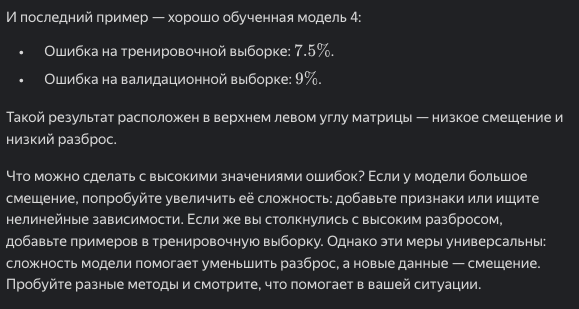

##### Выводы по смещению и разбросу

- При обучении модели неминуемо возникают ошибки, они включают в себя смещение и разброс. Проанализировав их значения, вы поймёте проблемы модели.
- Высокое смещение и низкий разброс говорят о недообучении, низкое смещение и высокий разброс — о переобучении.

- Каждый тип ошибок можно уменьшить при помощи усложнения модели и увеличения тренировочной выборки.

#### Регуляризация в логистической регрессии



Логистическая регрессия — это один из видов линейного уравнения. Чтобы применить к ней L1- и L2-регуляризации, нужно добавить в формулу штрафы за слишком высокие коэффициенты.

Для этого вы должны во время инициализации модели LogisticRegression() указать в настройке <font color='red'>penalty</font> , какой способ регуляризации вам подходит:

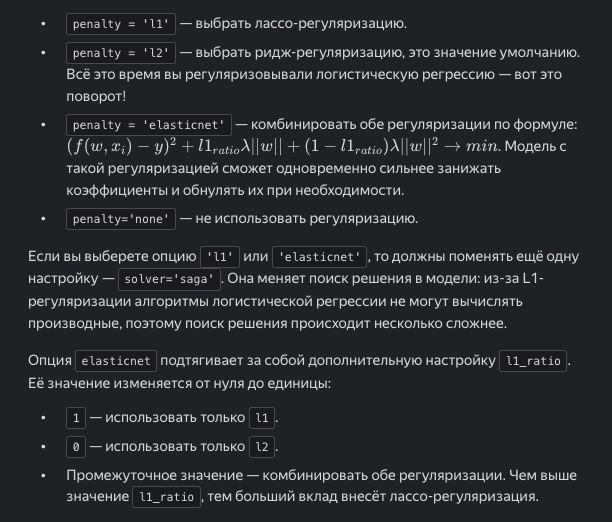

Также можно выбирать силу регуляризации, для этого существует опция C — сложность модели (англ. model capacity). Её значение по умолчанию — 1. Чем оно выше, тем более сложные зависимости в данных модель может восстанавливать. 

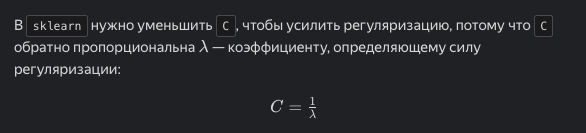

In [1]:
# импорт необходимых библиотек
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# объявляем константу random_state
RANDOM_STATE = 77

# объявляем переменную с данными
# выделяем целевой и входные признаки
data = pd.read_csv('orders_seafood.csv')
X = data.drop(columns=['target', 'client_id'])
y = data['target']

# делим данные на тренировочные и валидационные
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# стандартизируем выборки
scaler = StandardScaler()
X_train_scalled = scaler.fit_transform(X_train)
X_test_scalled = scaler.transform(X_test)

# обучаем модель линейной регрессии, получаем предсказания на тестовой выборке
# считаем accuracy
clf = LogisticRegression()
clf = clf.fit(X_train_scalled, y_train)
y_pred = clf.predict(X_test_scalled)
r = accuracy_score(y_test, y_pred)
print(r)

0.648936170212766


Коэффициенты (веса) ДО РЕГУЛЯРИЗАЦИИ

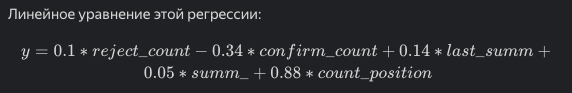

In [2]:
print(clf.coef_)

[[ 0.10094657 -0.33870607  0.1425265   0.04576941  0.87687396]]


Попытка № 1: 
- повысим мощность

In [3]:
clf_ridge = LogisticRegression(penalty = 'l2', C=15)
clf_ridge.fit(X_train_scalled, y_train)
y_pred = clf_ridge.predict(X_test_scalled)
r = accuracy_score(y_test, y_pred)
print(r)

print()

print(clf_ridge.coef_)

0.6436170212765957

[[ 0.09985383 -0.34390693  0.14278526 -0.22379382  1.15824723]]


Качество незначительно уменьшилось, а коэффициенты немного изменились — особенно у последних двух признаков:

Попытка 2: отключим регуляризацию

In [4]:
clf_no_reg = LogisticRegression(penalty = 'none')
clf_no_reg.fit(X_train_scalled, y_train)
y_pred = clf_no_reg.predict(X_test_scalled)
r = accuracy_score(y_test, y_pred)
print(r)

print()

print(clf_no_reg.coef_)

0.6436170212765957

[[ 0.0997266  -0.34435956  0.14271541 -0.25851538  1.19432564]]


Качество не изменилось, да и коэффициенты почти такие же.

Похоже, не стоит уменьшать коэффициенты, потому что модель не фокусирует внимание ни на одном из признаков. Но, возможно, есть такие, которые стоит убрать.

Попытка 3: регуляризация L1 и сниженная мощность С=0.1

In [9]:
# импорт необходимых библиотек
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# объявляем константу random_state
RANDOM_STATE = 77

# объявляем переменную с данными
# выделяем целевой и входные признаки
data = pd.read_csv('orders_seafood.csv')
X = data.drop(columns=['target', 'client_id'])
y = data['target']

# делим данные на тренировочные и валидационные
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# стандартизируйте выборки
scaler = StandardScaler()
X_train_scalled = scaler.fit_transform(X_train)
X_test_scalled = scaler.transform(X_test)

# обучите модель линейной регрессии, используйте L1-регуляризацию
clf = LogisticRegression(penalty='l1', C=0.1, solver='saga')
clf = clf.fit(X_train_scalled, y_train)
y_pred = clf.predict(X_test_scalled)

# рассчитайте и выведите accuracy
r = accuracy_score(y_test, y_pred)
print(r, clf.coef_)

0.675531914893617 [[ 0.03516607 -0.21153486  0.01830789  0.          0.76933772]]


Качество модели выросло, и теперь видно, в чём была проблема. Коэффициент признака summ_ принял значение 0.: оказалось, что его влияние на решение логистической регрессии лучше обнулить, чтобы модель лучше предсказывала отмену заказов.

#### Регуляризация в модели SVM

Аналогичный подход как с логрег не подойдет

Решение метода опорных векторов — это система из трёх неравенств, необходимых для поиска границы между наблюдениями разных классов. 

Коэффициенты wi
используются в них повсеместно. К примеру, они задают уравнение гиперплоскости, определяют расстояние между опорными векторами и гиперплоскостью, а также составляют вектор w
, который задаёт направление гиперплоскости. Поэтому их нельзя сократить или обнулить.

Метод 1: Коэффициент С

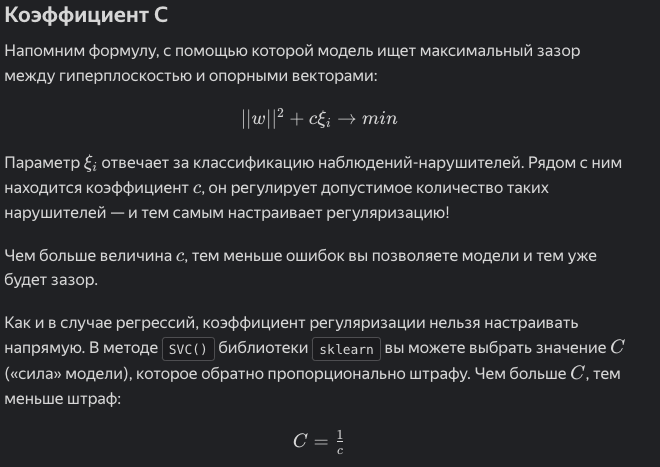

Если объект с явной нелинейной зависимостью как здесь

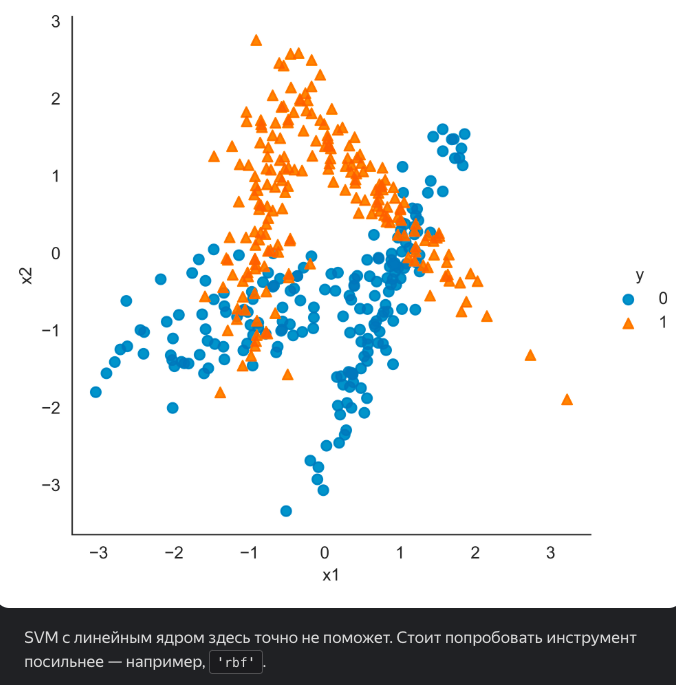

SVM c линейным ядром здесь точно не поможет. Стоит попробовать инструмент посильнее — например, 'rbf'. 

model = SVC(kernel = 'rbf', C=0.01) 

Настраиваем мощность С:

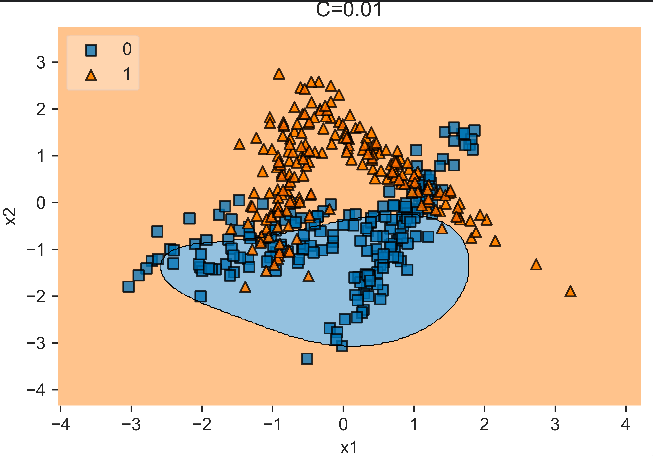

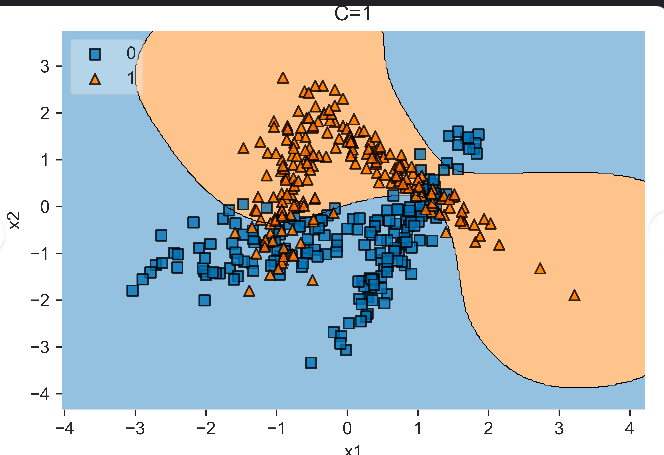

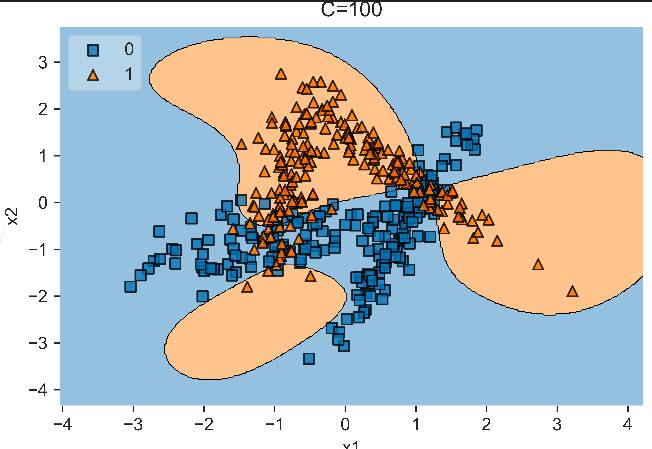

По мере роста 
C модель сильнее подстраивается под тренировочную выборку. 

Скорее всего, на каком-то моменте вам стоит прекратить его повышать: из-за переобучения предсказательные свойства модели на новых данных начнут падать.

Метод 2: Коэффициент γ

SVM может провести границы между классами по-разному — вариаций бесконечно много. Всё зависит от того, как объекты расположены в пространстве. Как вы помните, нелинейные ядра увеличивают размерность пространства, чтобы нелинейные данные было проще разделить гиперплоскостью. 

Вместе с изменением размерности пространства меняется и расположение отдельных объектов в нём. Какие-то пограничные наблюдения могут сместиться в «центр» класса, а выбросы — превратиться в типичные наблюдения. Соответственно, решение модели при увеличении размерности пространства также меняется.

В SVM масштаб того, насколько наблюдения «разнесёт» в многомерном пространстве, определяет коэффициент 
γ (гамма). Он есть только в формулах нелинейных ядер. Чем выше значение 
γ, тем дальше друг от друга будут расположены наблюдения разных классов в пространстве увеличенной размерности и тем проще будет провести между ними границу.

Значение
γ можно выбрать напрямую во время инициализации модели:

model = SVC(kernel = 'rbf', gamma=0.01)

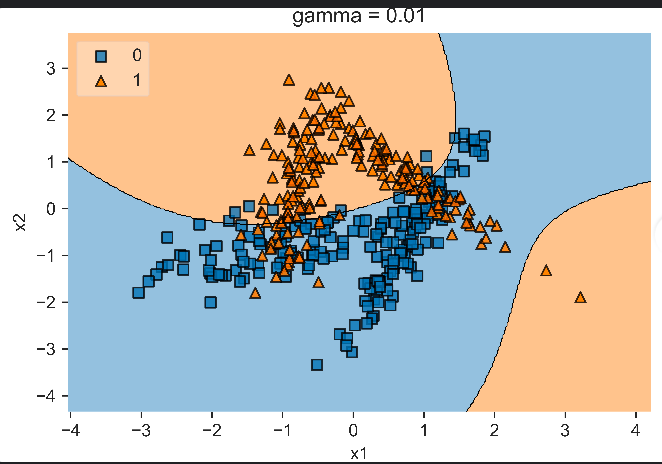

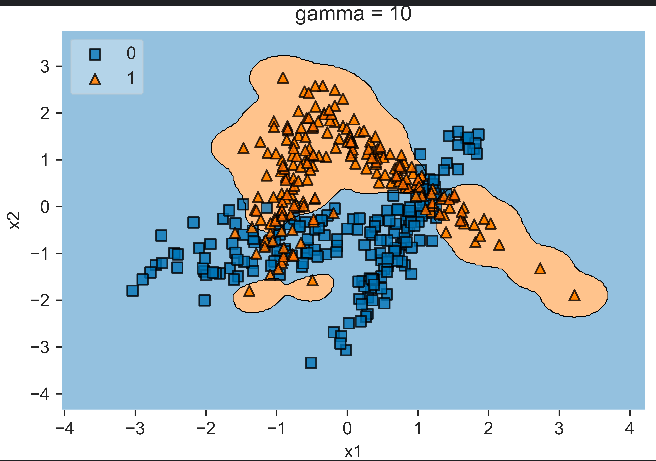

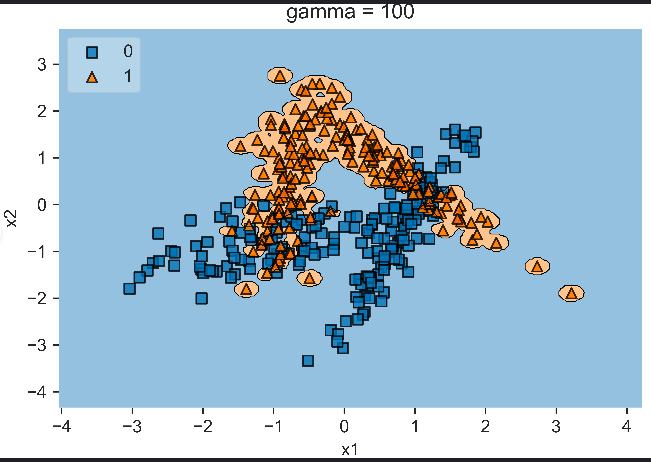


С ростом 
γ граница классов всё ближе подбирается к каждому наблюдению в двумерном пространстве. Если ещё сильнее подкрутить его значение, то модель и вовсе не будет проводить никаких границ и выдаст очевидный факт — «объекты класса 1 принадлежат к классу 1». 

И будет права — но только на тренировочной выборке. 

        Представьте, как сильно она переобучится… 
        
        Поэтому стоит понизить γ, если вы обнаружите переобучение.



Что выбрать - метод 1 или метод 2?

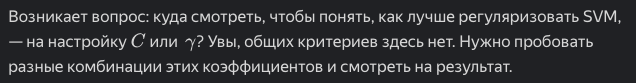

In [2]:
# импорт необходимых библиотек
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# объявляем константу random_state
RANDOM_STATE = 77

# объявляем переменную с данными
# выделяем целевой и входные признаки
data = pd.read_csv('orders_seafood.csv')
X = data.drop(columns=['target', 'client_id'])
y = data['target']

# делим данные на тренировочные и валидационные
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# стандартизируем выборки
scaler = StandardScaler()
X_train_scalled = scaler.fit_transform(X_train)
X_test_scalled = scaler.transform(X_test)

# добавляем тестовые данные, выделяем целевой признак, стандартизируем выборку
test_data = pd.read_csv('orders_seafood_test.csv')
test_x = test_data.drop(columns=['client_id', 'target'])
test_y = test_data['target']
test_data_scalled = scaler.transform(test_x)

# списки со значениями настроей для регуляризации
C_ = [0.1,1,10,100]
gamma_ = [0.1,1,10,100]

"""
# обучаем модель и смотрим на результаты модели при регуляризации разной силы
for C in C_:
    for gamma in gamma_:
        clf_poly = SVC(kernel = 'poly', degree = 2, C = C, gamma = gamma)
        clf_poly.fit(X_train_scalled, y_train)
        y_pred_poly = clf_poly.predict(X_test_scalled)
        y_pred_test = clf_poly.predict(test_data_scalled)
        r0 = accuracy_score(y_train, clf_poly.predict(X_train_scalled))
        r = accuracy_score(y_test, y_pred_poly)
        r1 = accuracy_score(test_y, y_pred_test)
        print(C,gamma, round(r0,2), round(r,2), round(r1,2))

"""

"\n# обучаем модель и смотрим на результаты модели при регуляризации разной силы\nfor C in C_:\n    for gamma in gamma_:\n        clf_poly = SVC(kernel = 'poly', degree = 2, C = C, gamma = gamma)\n        clf_poly.fit(X_train_scalled, y_train)\n        y_pred_poly = clf_poly.predict(X_test_scalled)\n        y_pred_test = clf_poly.predict(test_data_scalled)\n        r0 = accuracy_score(y_train, clf_poly.predict(X_train_scalled))\n        r = accuracy_score(y_test, y_pred_poly)\n        r1 = accuracy_score(test_y, y_pred_test)\n        print(C,gamma, round(r0,2), round(r,2), round(r1,2))\n\n"

Код выводить не будем, цикл слишком ресурсозатратный.

В результате выйдет это

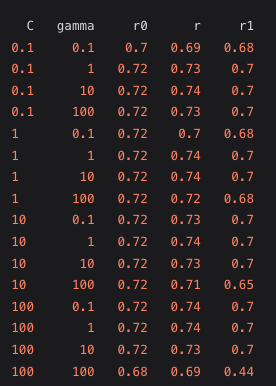

Что дала настройка?

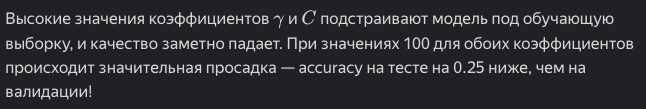

Это указывает на то, что распределение признаков в тренировочной и тестовой выборках заметно различается. Похоже, произошли структурные изменения, о которых модель не знала и поэтому не учла.

У этого может быть много причин: например, в меню появились новые позиции, исчезла часть старых, выросла цена на блюда или появились промоакции или предоплаты заказов. Специалисты по Data Science должны отслеживать такие изменения, чтобы поддерживать модель в актуальном состоянии.

У этого может быть много причин: например, в меню появились новые позиции, исчезла часть старых, выросла цена на блюда или появились промоакции или предоплаты заказов. Специалисты по Data Science должны отслеживать такие изменения, чтобы поддерживать модель в актуальном состоянии.

В вашем случае всё оказалось просто: похоже, ещё до внедрения модели заказчик решил ввести предоплату! Правда, опирался он не на модель машинного обучения, а просто ввёл её на все заказы. Вот бы ещё вам эту информацию сообщили вовремя…

К сожалению, такие форс-мажоры случаются. Вряд ли вы узнаете всё о бизнесе заказчика, но в вашей власти — работа с данными. Сравнив старый и новый датасет, можно узнать, что же поменялось. Для этого не нужно изучать все наблюдения — достаточно изучить описательные статистики.

In [3]:
data_test = data.drop(columns=['client_id'])
data_test.describe()

reject_count  confirm_count      last_summ         summ_  \
count    750.000000     750.000000     750.000000    750.000000   
mean      20.524000      43.281333  117236.968533  13642.938933   
std        6.190896      55.671117   33535.611602  11264.546470   
min        5.000000       5.000000   32896.400000   1460.100000   
25%       16.000000      14.000000   98092.800000   5028.400000   
50%       21.000000      17.000000  120045.100000   8134.700000   
75%       25.000000      24.750000  142483.850000  22788.950000   
max       39.000000     204.000000  191564.800000  69465.900000   

       count_position      target  
count      750.000000  750.000000  
mean         8.010667    0.700000  
std          6.231184    0.458563  
min          1.000000    0.000000  
25%          3.000000    0.000000  
50%          5.000000    1.000000  
75%         13.000000    1.000000  
max         30.000000    1.000000

Сравнивая данные, в первую очередь смотрите на медиану, а не на среднее — это более **робастная** оценка распределения.

Обратите внимание на медианы признаков reject_count и summ_. Количество отказов существенно сократилось — предоплата оправдала себя. Но это не отменяет того, что её можно вводить более точечно и с большей эффективностью, поэтому ваша модель всё ещё востребована. Теперь её пора адаптировать под новые реалии.

##### Финальное решение - Что использовать?

Из-за таких структурных изменений больше нельзя просто использовать старую тренировочную выборку для обучения модели — теперь она стала аномальной. Вот что с этим можно сделать:

1) Удалить наблюдения, где значение признака reject_count сильно выше, чем в новых данных. Так исходные данные будут выровнены под новую тестовую выборку.

2) Использовать для обучения тестовую выборку.

Второй вариант предпочтительнее. Это связано с тем, что в случае с «Морскими вкусняхами» структурные изменения нельзя экстраполировать на старые данные. Отмены заказов в прошлом никак не связаны с нововведениями, и даже клиенты с тем же количеством отмен могли их делать по другой причине. 

Обучим модель SVC() с разными ядрами: 'rbf', 'sigmoid', 'linear', 'poly'. Для полиномиального ядра используйте полином второй степени. Выведите на экран тип ядра и значения accuracy.

In [4]:
# импорт необходимых библиотек
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# объявляем константу random_state
RANDOM_STATE = 77

# объявляем переменную с данными
# выделяем целевой и входные признаки
data_test = pd.read_csv('orders_seafood_test.csv')
X = data_test.drop(columns=['target', 'client_id'])
y = data_test['target']

# делим данные на тренировочные и валидационные
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# стандартизируем выборки
scaler = StandardScaler()
X_train_scalled = scaler.fit_transform(X_train)
X_test_scalled = scaler.transform(X_test)

# с помощью цикла обучите SVC с разными ядрами
# получите предсказание на валидационной выборке и посчитайте accuracy
kernels = ['rbf','sigmoid', 'linear', 'poly']
for kernel in kernels:
    if kernel!='poly':
        svc = SVC(kernel = kernel)
    else:
        svc = SVC(kernel = kernel, degree=2)
    svc.fit(X_train_scalled, y_train)
    y_pred = svc.predict(X_test_scalled)
    accuracy = accuracy_score(y_test, y_pred)
    print(kernel, accuracy)

rbf 0.72
sigmoid 0.66
linear 0.78
poly 0.66


А если добавить регуляризацию?

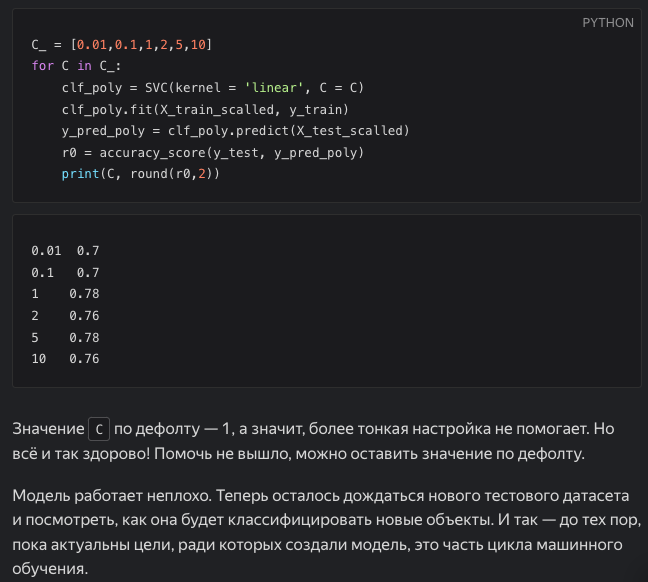

#### Выводы
- SVM поддерживает регуляризацию двумя способами — при помощи изменения коэффициентов γ и С

- C отвечает за количество ошибок классификации. Чем он выше, тем слабее регуляризация.
- γ настраивает порог при поиске опорных векторов. Чем он выше, тем более близко к наблюдениям класса 1 проходят границы этого класса.
- Если тренировочные и тестовые данные сильно различаются и различия между ними нельзя устранить предобработкой данных, используйте тестовый датасет как обучающий, чтобы новая модель обладала лучшими прогностическими свойствами.